In [91]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments,DataCollatorForLanguageModeling

from copy import deepcopy
from torch.utils.data import Dataset
import tqdm
import csv
from torch.utils.data import DataLoader

import pandas as pd
from sklearn.metrics import accuracy_score,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score

from sklearn.utils import compute_class_weight

import evaluate

accuracy = evaluate.load("accuracy")
balanced_accuracy = evaluate.load("hyperml/balanced_accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")
roc_auc = evaluate.load("roc_auc")

import numpy as np
def compute_metrics(eval_pred):
    # print(eval_pred)
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"balanced_accuracy":round(balanced_accuracy.compute(predictions=predictions, references=labels)['balanced_accuracy'],2),"precision":round(precision.compute(predictions=predictions, references=labels)['precision'],2),"recall":round(recall.compute(predictions=predictions, references=labels)['recall'],2),"f1":round(f1.compute(predictions=predictions, references=labels)['f1'],2)} #,round(roc_auc.compute(predictions=predictions, references=labels)['roc_auc'],2))

import matplotlib.pyplot as plt


### Language models

In [92]:
class TwitterDataset(Dataset):
    """
    Implement TwitterDataset in Pytorch
    """
    def __init__(self, path, tokenizer, device):
        
        self.label_to_id = {"no_answer": 0, "answer": 1}
        self.id_to_label = {0: "no_answer", 1: "answer"}
        
        self.tokenizer = tokenizer
        self.pad_id=tokenizer.encode(tokenizer.pad_token,add_special_tokens=False)[0]
        self.text_samples = []
        self.labels = []
        self.samples=[]
        
        print("Building Twitter Dataset...")
        
        with open(path, "r") as read_obj:
            reader = csv.reader(read_obj)
            for ind,sample in enumerate(reader):
                if ind!=0:
                    # print(sample[4])
                
                    self.text_samples.append(sample[4])
                    # tokens=tokenizer(sample[4],return_tensors="pt")
                    # tokens['input_ids']=tokens['input_ids'].squeeze(0)
                    # tokens['attention_mask']=tokens['attention_mask'].squeeze(0)
                    label=torch.tensor(int(sample[8]))
                    tokenized=tokenizer(sample[4],return_tensors="pt",padding=True,truncation=True)
                    # print(sample[4])
                    dictionary={"text": sample[4], "label": int(sample[8])}
                    tokenized['input_ids']=tokenized['input_ids'].squeeze(0).to(device)
                    tokenized['attention_mask']=tokenized['attention_mask'].squeeze(0).to(device)
                    
                    for key in tokenized.keys():
                        dictionary[key]=tokenized[key]
                    self.samples.append(dictionary)


    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        return deepcopy(self.samples[index])
    
    
    
    def collate_fn(self, batch):
        
        batch_text = [sample['text'] for sample in batch]
        batch_ids=self.tokenizer(batch_text,return_tensors="pt",padding=True) #for sample in batch_padded]
        
        tensor_batch_ids = batch_ids #torch.tensor(batch_ids)
        
        batch_labels = [sample['label'] for sample in batch]
        tensor_labels = torch.tensor(batch_labels).long()
        
        return tensor_batch_ids, tensor_labels
    

In [93]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
print(device)

cuda


In [109]:
def evaluation(model,dataset_name, eval_data,device):
    # this function should be called in the train loop to monitor the performance in validation set while training.
    
    model.eval()
    
    with torch.no_grad():
        epoch_loss=0
        predictions=[]
        targets=[]
        for data in tqdm.tqdm(eval_data,desc="Testing"):
            # YOUR CODE HERE
            loss=0
            
            inputs,labels=data

            out=model(**inputs.to(device), labels=labels.to(device))
            model_loss=out.loss
            targets.extend(labels.tolist())
            predictions.extend(out.logits.argmax(dim=-1).tolist())
            loss+=model_loss
                
            epoch_loss+=loss.item()/len(data)


        print("Evaluation for dataset "+dataset_name)
        ba=balanced_accuracy_score(targets, predictions)
        pr=precision_score(targets, predictions)
        rec=recall_score(targets, predictions)
        f1=f1_score(targets, predictions)
        print(f"Test model loss={epoch_loss / len(eval_data)}")
        print(f"Balanced_accuracy: {ba}")
        print(f"Precision: {pr}")
        print(f"Recall: {rec}")
        print(f"F1: {f1}")
        try:
            print(f"Roc_auc: {roc_auc_score(targets, predictions)}")
        except:
            print("Impossible to define ROC_AUC - only one class presents!")
    print(f"Number of ones in predictions: {sum(predictions)}")
    print(f"Number of predictions: {len(predictions)}\n")
    return predictions,targets,ba,pr,rec,f1

In [158]:
def evaluate_all_datasets(model):
    well_answering=TwitterDataset(f"./data/test_wa_{name}.csv",tokenizer,device)
    well_answering_data_loader=DataLoader(well_answering,batch_size=10,shuffle=False,collate_fn=train_data.collate_fn)
    wa=evaluation(model,"well_answering",well_answering_data_loader,device)
    
    wa_only_ones=TwitterDataset(f"./data/oo_wa_{name}.csv",tokenizer,device)
    wa_only_ones_data_loader=DataLoader(wa_only_ones,batch_size=10,shuffle=False,collate_fn=train_data.collate_fn)
    wa_oo=evaluation(model,"well_answering only ones",wa_only_ones_data_loader,device)
    
    wa_only_zeros=TwitterDataset(f"./data/oz_wa_{name}.csv",tokenizer,device)
    wa_only_zeros_data_loader=DataLoader(wa_only_zeros,batch_size=10,shuffle=False,collate_fn=train_data.collate_fn)
    wa_oz=evaluation(model,"well_answering only zeros",wa_only_zeros_data_loader,device)
    
    low_answering=TwitterDataset(f"./data/la_10k_{name}.csv",tokenizer,device)
    low_answering_data_loader=DataLoader(low_answering,batch_size=10,shuffle=False,collate_fn=train_data.collate_fn)
    la=evaluation(model,"low_answering",low_answering_data_loader,device)

    only_ones=TwitterDataset(f"./data/oo_{name}.csv",tokenizer,device)
    only_ones_data_loader=DataLoader(only_ones,batch_size=10,shuffle=False,collate_fn=train_data.collate_fn)
    oo=evaluation(model,"low_answering only ones",only_ones_data_loader,device)
    
    only_zeros=TwitterDataset(f"./data/oz_10k_{name}.csv",tokenizer,device)
    only_zeros_data_loader=DataLoader(only_zeros,batch_size=10,shuffle=False,collate_fn=train_data.collate_fn)
    oz=evaluation(model,"low_answering only zeros",only_zeros_data_loader,device)
    
    
    metrics=["balanced_accuracy","precision","recall","f1"]
    fig, ax = plt.subplots()
    ax.bar(np.arange(4),[wa[2],wa[3],wa[4],wa[5]],width=0.15,align='edge')
    ax.bar(np.arange(4)+0.15,[wa_oo[2],wa_oo[3],wa_oo[4],wa_oo[5]],width=0.15,align='edge')
    ax.bar(np.arange(4)+0.3,[wa_oz[2],wa_oz[3],wa_oz[4],wa_oz[5]],width=0.15,align='edge')
    ax.bar(np.arange(4)+0.45,[la[2],la[3],la[4],la[5]],width=0.15,align='edge')
    ax.bar(np.arange(4)+0.60,[oo[2],oo[3],oo[4],oo[5]],width=0.15,align='edge')
    ax.bar(np.arange(4)+0.75,[oz[2],oz[3],oz[4],oz[5]],width=0.15,align='edge')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = [metrics[ind//2-1] if (ind%2==0) and (ind!=len(labels)-1) and (ind!=0) else '' for ind,label in enumerate(labels) ]
    ax.set_xticklabels(labels)
    # plt.plot(metrics, [wa[2],wa[3],wa[4],wa[5]],'1')
    # plt.plot(metrics,[wa_oo[2],wa_oo[3],wa_oo[4],wa_oo[5]],'2')
    # plt.plot(metrics,[wa_oz[2],wa_oz[3],wa_oz[4],wa_oz[5]],'3')
    # plt.plot(metrics,[la[2],la[3],la[4],la[5]],'4')
    # plt.plot(metrics,[oo[2],oo[3],oo[4],oo[5]],'8')
    # plt.plot(metrics,[oz[2],oz[3],oz[4],oz[5]],'s')
    ax.legend(["wa","wa_oo","wa_oz","la","la_oo","la_oz"])
    plt.xlabel("metrics")
    plt.ylabel("value")
    plt.title(name)
    
    return wa[0:2],wa_oo[:2],wa_oz[:2],la[:2],oo[:2],oz[:2]

In [118]:
def training(name,num_epochs):
    run_name = f"well-answering-{name}"
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=2)
    model=model.to(device)
    
    train_data=TwitterDataset(f"./data/train_wa_{name}.csv",tokenizer,device)
    test_data=TwitterDataset(f"./data/eval_wa_{name}.csv",tokenizer,device)
    
    labels=[]
    for i in train_data:
        labels.append(i['label'])
    # for i in test_data:
    #     labels.append(i['label'])
        
    class_weights=compute_class_weight('balanced',classes=np.unique(labels),y=np.array(labels))
    class_weights=torch.tensor(class_weights,dtype=torch.float,device=device)
    
    class CustomTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False):
            # print(inputs)
            labels = inputs.get("labels")
            # forward pass
            outputs = model(**inputs)
            logits = outputs.get("logits")
            # # compute custom loss (suppose one has 3 labels with different weights)
            loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights,reduction='mean') #weight=torch.tensor([1.0, 2.0, 3.0])
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
            return (loss, outputs) if return_outputs else loss
        
    training_args = TrainingArguments(
        output_dir=f"models/{run_name}",
        num_train_epochs=num_epochs,
        evaluation_strategy = "epoch",
        logging_steps=100,
        per_device_train_batch_size=8,
        learning_rate=0.000005,
        weight_decay=0.01)
    
    trainer = CustomTrainer(model=model,
                        args=training_args,
                        train_dataset=train_data,
                        eval_dataset=test_data,
                        tokenizer=tokenizer,
                        compute_metrics=compute_metrics
                        )
    
    return trainer

In [97]:
def plot_save_results(trainer,name):
    train_epoch=[]
    train_loss=[]

    eval_epoch=[]
    eval_loss=[]
    eval_acc=[]
    eval_f1=[]
    for i in trainer.state.log_history:
        try:
            if 'eval_loss' in i.keys():
                eval_loss.append(i['eval_loss'])
                eval_epoch.append(i['epoch'])
                eval_acc.append(i['eval_balanced_accuracy'])
                eval_f1.append(i['eval_f1'])
            else:
                train_loss.append(i['loss'])
                train_epoch.append(i['epoch'])
        except:
            pass
    
    f=open(name+'.txt','a')
    f.write(str(trainer.state.log_history))
    f.close()

    plt.plot(train_epoch,train_loss)
    plt.plot(eval_epoch,eval_loss,'ro-.')
    plt.plot(eval_epoch,eval_acc,'go--')
    plt.plot(eval_epoch,eval_f1,'mo:')
    plt.legend(["train_loss","eval_loss","eval_balanced_accuracy","eval_f1"])
    plt.xlabel("#epoch")
    plt.ylabel("loss")
    plt.title(name)
    None

### NGOs

In [98]:
name="ngos"

In [100]:
trainer=training(name,10)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Building Twitter Dataset...
Building Twitter Dataset...


In [101]:
trainer.train()

c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\transformers\optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/41220 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6598, 'learning_rate': 4.9878699660359055e-06, 'epoch': 0.02}
{'loss': 0.6439, 'learning_rate': 4.975739932071811e-06, 'epoch': 0.05}
{'loss': 0.7112, 'learning_rate': 4.963609898107715e-06, 'epoch': 0.07}
{'loss': 0.9999, 'learning_rate': 4.95147986414362e-06, 'epoch': 0.1}
{'loss': 0.911, 'learning_rate': 4.939349830179525e-06, 'epoch': 0.12}
{'loss': 0.9366, 'learning_rate': 4.92721979621543e-06, 'epoch': 0.15}
{'loss': 1.0067, 'learning_rate': 4.915089762251335e-06, 'epoch': 0.17}
{'loss': 0.891, 'learning_rate': 4.90295972828724e-06, 'epoch': 0.19}
{'loss': 0.9437, 'learning_rate': 4.890829694323144e-06, 'epoch': 0.22}
{'loss': 0.9007, 'learning_rate': 4.878699660359049e-06, 'epoch': 0.24}
{'loss': 0.9309, 'learning_rate': 4.866569626394954e-06, 'epoch': 0.27}
{'loss': 0.9191, 'learning_rate': 4.854439592430859e-06, 'epoch': 0.29}
{'loss': 0.9689, 'learning_rate': 4.842309558466764e-06, 'epoch': 0.32}
{'loss': 0.6748, 'learning_rate': 4.830179524502669e-06, 'epoch': 0.3

  0%|          | 0/773 [00:00<?, ?it/s]

{'eval_loss': 0.8365477919578552, 'eval_balanced_accuracy': 0.66, 'eval_precision': 0.92, 'eval_recall': 0.32, 'eval_f1': 0.48, 'eval_runtime': 11.5415, 'eval_samples_per_second': 535.634, 'eval_steps_per_second': 66.976, 'epoch': 1.0}
{'loss': 0.8515, 'learning_rate': 4.490538573508006e-06, 'epoch': 1.02}
{'loss': 0.7661, 'learning_rate': 4.478408539543911e-06, 'epoch': 1.04}
{'loss': 0.7101, 'learning_rate': 4.466278505579815e-06, 'epoch': 1.07}
{'loss': 0.7482, 'learning_rate': 4.4541484716157205e-06, 'epoch': 1.09}
{'loss': 0.7522, 'learning_rate': 4.442018437651626e-06, 'epoch': 1.12}
{'loss': 0.8038, 'learning_rate': 4.429888403687531e-06, 'epoch': 1.14}
{'loss': 0.5901, 'learning_rate': 4.417758369723435e-06, 'epoch': 1.16}
{'loss': 0.6102, 'learning_rate': 4.40562833575934e-06, 'epoch': 1.19}
{'loss': 0.8144, 'learning_rate': 4.393498301795245e-06, 'epoch': 1.21}
{'loss': 0.6711, 'learning_rate': 4.3813682678311505e-06, 'epoch': 1.24}
{'loss': 0.6673, 'learning_rate': 4.3692382

  0%|          | 0/773 [00:00<?, ?it/s]

{'eval_loss': 0.7106090188026428, 'eval_balanced_accuracy': 0.69, 'eval_precision': 0.87, 'eval_recall': 0.38, 'eval_f1': 0.53, 'eval_runtime': 11.6454, 'eval_samples_per_second': 530.854, 'eval_steps_per_second': 66.378, 'epoch': 2.0}
{'loss': 0.7369, 'learning_rate': 3.993207180980107e-06, 'epoch': 2.01}
{'loss': 0.5901, 'learning_rate': 3.981077147016012e-06, 'epoch': 2.04}
{'loss': 0.6783, 'learning_rate': 3.968947113051917e-06, 'epoch': 2.06}
{'loss': 0.6761, 'learning_rate': 3.956817079087822e-06, 'epoch': 2.09}
{'loss': 0.7096, 'learning_rate': 3.944687045123727e-06, 'epoch': 2.11}
{'loss': 0.6831, 'learning_rate': 3.932557011159632e-06, 'epoch': 2.13}
{'loss': 0.7687, 'learning_rate': 3.920426977195536e-06, 'epoch': 2.16}
{'loss': 0.6887, 'learning_rate': 3.9082969432314415e-06, 'epoch': 2.18}
{'loss': 0.5911, 'learning_rate': 3.896166909267347e-06, 'epoch': 2.21}
{'loss': 0.7745, 'learning_rate': 3.884036875303251e-06, 'epoch': 2.23}
{'loss': 0.5962, 'learning_rate': 3.8719068

  0%|          | 0/773 [00:00<?, ?it/s]

{'eval_loss': 0.7313843965530396, 'eval_balanced_accuracy': 0.69, 'eval_precision': 0.94, 'eval_recall': 0.39, 'eval_f1': 0.55, 'eval_runtime': 12.5723, 'eval_samples_per_second': 491.715, 'eval_steps_per_second': 61.484, 'epoch': 3.0}
{'loss': 0.646, 'learning_rate': 3.495875788452208e-06, 'epoch': 3.01}
{'loss': 0.5957, 'learning_rate': 3.4837457544881124e-06, 'epoch': 3.03}
{'loss': 0.7089, 'learning_rate': 3.4716157205240176e-06, 'epoch': 3.06}
{'loss': 0.6203, 'learning_rate': 3.4594856865599223e-06, 'epoch': 3.08}
{'loss': 0.7394, 'learning_rate': 3.4473556525958274e-06, 'epoch': 3.11}
{'loss': 0.7349, 'learning_rate': 3.435225618631732e-06, 'epoch': 3.13}
{'loss': 0.6975, 'learning_rate': 3.4230955846676373e-06, 'epoch': 3.15}
{'loss': 0.7212, 'learning_rate': 3.410965550703542e-06, 'epoch': 3.18}
{'loss': 0.6658, 'learning_rate': 3.398835516739447e-06, 'epoch': 3.2}
{'loss': 0.4998, 'learning_rate': 3.3867054827753522e-06, 'epoch': 3.23}
{'loss': 0.6601, 'learning_rate': 3.3745

  0%|          | 0/773 [00:00<?, ?it/s]

{'eval_loss': 0.594247043132782, 'eval_balanced_accuracy': 0.75, 'eval_precision': 0.96, 'eval_recall': 0.49, 'eval_f1': 0.65, 'eval_runtime': 11.7878, 'eval_samples_per_second': 524.439, 'eval_steps_per_second': 65.576, 'epoch': 4.0}
{'loss': 0.722, 'learning_rate': 2.998544395924309e-06, 'epoch': 4.0}
{'loss': 0.5491, 'learning_rate': 2.9864143619602137e-06, 'epoch': 4.03}
{'loss': 0.5706, 'learning_rate': 2.974284327996119e-06, 'epoch': 4.05}
{'loss': 0.6097, 'learning_rate': 2.9621542940320236e-06, 'epoch': 4.08}
{'loss': 0.5972, 'learning_rate': 2.9500242600679287e-06, 'epoch': 4.1}
{'loss': 0.5785, 'learning_rate': 2.9378942261038334e-06, 'epoch': 4.12}
{'loss': 0.4923, 'learning_rate': 2.9257641921397385e-06, 'epoch': 4.15}
{'loss': 0.5546, 'learning_rate': 2.9136341581756433e-06, 'epoch': 4.17}
{'loss': 0.4994, 'learning_rate': 2.9015041242115484e-06, 'epoch': 4.2}
{'loss': 0.4797, 'learning_rate': 2.889374090247453e-06, 'epoch': 4.22}
{'loss': 0.6323, 'learning_rate': 2.877244

  0%|          | 0/773 [00:00<?, ?it/s]

{'eval_loss': 0.49495020508766174, 'eval_balanced_accuracy': 0.82, 'eval_precision': 0.93, 'eval_recall': 0.64, 'eval_f1': 0.76, 'eval_runtime': 11.6036, 'eval_samples_per_second': 532.766, 'eval_steps_per_second': 66.617, 'epoch': 5.0}
{'loss': 0.5796, 'learning_rate': 2.4890829694323146e-06, 'epoch': 5.02}
{'loss': 0.5293, 'learning_rate': 2.4769529354682197e-06, 'epoch': 5.05}
{'loss': 0.4958, 'learning_rate': 2.4648229015041244e-06, 'epoch': 5.07}
{'loss': 0.539, 'learning_rate': 2.4526928675400296e-06, 'epoch': 5.09}
{'loss': 0.6578, 'learning_rate': 2.4405628335759343e-06, 'epoch': 5.12}
{'loss': 0.6587, 'learning_rate': 2.428432799611839e-06, 'epoch': 5.14}
{'loss': 0.6177, 'learning_rate': 2.4163027656477437e-06, 'epoch': 5.17}
{'loss': 0.5402, 'learning_rate': 2.404172731683649e-06, 'epoch': 5.19}
{'loss': 0.5393, 'learning_rate': 2.392042697719554e-06, 'epoch': 5.22}
{'loss': 0.6298, 'learning_rate': 2.3799126637554587e-06, 'epoch': 5.24}
{'loss': 0.5066, 'learning_rate': 2.3

  0%|          | 0/773 [00:00<?, ?it/s]

{'eval_loss': 0.4313172996044159, 'eval_balanced_accuracy': 0.85, 'eval_precision': 0.97, 'eval_recall': 0.7, 'eval_f1': 0.81, 'eval_runtime': 11.5997, 'eval_samples_per_second': 532.944, 'eval_steps_per_second': 66.64, 'epoch': 6.0}
{'loss': 0.4736, 'learning_rate': 1.9917515769044154e-06, 'epoch': 6.02}
{'loss': 0.473, 'learning_rate': 1.9796215429403206e-06, 'epoch': 6.04}
{'loss': 0.3784, 'learning_rate': 1.9674915089762253e-06, 'epoch': 6.07}
{'loss': 0.5103, 'learning_rate': 1.9553614750121304e-06, 'epoch': 6.09}
{'loss': 0.5498, 'learning_rate': 1.943231441048035e-06, 'epoch': 6.11}
{'loss': 0.4833, 'learning_rate': 1.9311014070839403e-06, 'epoch': 6.14}
{'loss': 0.4167, 'learning_rate': 1.9189713731198446e-06, 'epoch': 6.16}
{'loss': 0.5723, 'learning_rate': 1.9068413391557497e-06, 'epoch': 6.19}
{'loss': 0.4348, 'learning_rate': 1.8947113051916546e-06, 'epoch': 6.21}
{'loss': 0.4597, 'learning_rate': 1.8825812712275595e-06, 'epoch': 6.23}
{'loss': 0.4388, 'learning_rate': 1.87

  0%|          | 0/773 [00:00<?, ?it/s]

{'eval_loss': 0.3261067569255829, 'eval_balanced_accuracy': 0.88, 'eval_precision': 0.95, 'eval_recall': 0.77, 'eval_f1': 0.85, 'eval_runtime': 11.8406, 'eval_samples_per_second': 522.104, 'eval_steps_per_second': 65.284, 'epoch': 7.0}
{'loss': 0.5179, 'learning_rate': 1.4944201843765163e-06, 'epoch': 7.01}
{'loss': 0.3164, 'learning_rate': 1.4822901504124212e-06, 'epoch': 7.04}
{'loss': 0.2695, 'learning_rate': 1.4701601164483261e-06, 'epoch': 7.06}
{'loss': 0.5004, 'learning_rate': 1.458030082484231e-06, 'epoch': 7.08}
{'loss': 0.3968, 'learning_rate': 1.445900048520136e-06, 'epoch': 7.11}
{'loss': 0.3589, 'learning_rate': 1.433770014556041e-06, 'epoch': 7.13}
{'loss': 0.4667, 'learning_rate': 1.4216399805919458e-06, 'epoch': 7.16}
{'loss': 0.3943, 'learning_rate': 1.4095099466278506e-06, 'epoch': 7.18}
{'loss': 0.4082, 'learning_rate': 1.3973799126637555e-06, 'epoch': 7.21}
{'loss': 0.3916, 'learning_rate': 1.3852498786996604e-06, 'epoch': 7.23}
{'loss': 0.5366, 'learning_rate': 1.3

  0%|          | 0/773 [00:00<?, ?it/s]

{'eval_loss': 0.29819348454475403, 'eval_balanced_accuracy': 0.9, 'eval_precision': 0.98, 'eval_recall': 0.8, 'eval_f1': 0.88, 'eval_runtime': 12.0359, 'eval_samples_per_second': 513.63, 'eval_steps_per_second': 64.225, 'epoch': 8.0}
{'loss': 0.5312, 'learning_rate': 9.970887918486174e-07, 'epoch': 8.01}
{'loss': 0.423, 'learning_rate': 9.84958757884522e-07, 'epoch': 8.03}
{'loss': 0.5574, 'learning_rate': 9.72828723920427e-07, 'epoch': 8.05}
{'loss': 0.3517, 'learning_rate': 9.60698689956332e-07, 'epoch': 8.08}
{'loss': 0.2818, 'learning_rate': 9.485686559922369e-07, 'epoch': 8.1}
{'loss': 0.3643, 'learning_rate': 9.364386220281417e-07, 'epoch': 8.13}
{'loss': 0.4352, 'learning_rate': 9.243085880640466e-07, 'epoch': 8.15}
{'loss': 0.2852, 'learning_rate': 9.121785540999515e-07, 'epoch': 8.18}
{'loss': 0.3393, 'learning_rate': 9.000485201358565e-07, 'epoch': 8.2}
{'loss': 0.4397, 'learning_rate': 8.879184861717613e-07, 'epoch': 8.22}
{'loss': 0.3881, 'learning_rate': 8.757884522076662e

  0%|          | 0/773 [00:00<?, ?it/s]

{'eval_loss': 0.2542320191860199, 'eval_balanced_accuracy': 0.92, 'eval_precision': 0.99, 'eval_recall': 0.83, 'eval_f1': 0.9, 'eval_runtime': 11.7323, 'eval_samples_per_second': 526.922, 'eval_steps_per_second': 65.887, 'epoch': 9.0}
{'loss': 0.3828, 'learning_rate': 4.997573993207181e-07, 'epoch': 9.0}
{'loss': 0.3825, 'learning_rate': 4.876273653566231e-07, 'epoch': 9.02}
{'loss': 0.2454, 'learning_rate': 4.7549733139252793e-07, 'epoch': 9.05}
{'loss': 0.4497, 'learning_rate': 4.6336729742843285e-07, 'epoch': 9.07}
{'loss': 0.2628, 'learning_rate': 4.512372634643378e-07, 'epoch': 9.1}
{'loss': 0.2182, 'learning_rate': 4.3910722950024265e-07, 'epoch': 9.12}
{'loss': 0.3392, 'learning_rate': 4.269771955361476e-07, 'epoch': 9.15}
{'loss': 0.427, 'learning_rate': 4.1484716157205245e-07, 'epoch': 9.17}
{'loss': 0.2735, 'learning_rate': 4.0271712760795737e-07, 'epoch': 9.19}
{'loss': 0.3595, 'learning_rate': 3.9058709364386224e-07, 'epoch': 9.22}
{'loss': 0.2522, 'learning_rate': 3.784570

  0%|          | 0/773 [00:00<?, ?it/s]

{'eval_loss': 0.25176677107810974, 'eval_balanced_accuracy': 0.92, 'eval_precision': 0.98, 'eval_recall': 0.84, 'eval_f1': 0.9, 'eval_runtime': 12.3091, 'eval_samples_per_second': 502.229, 'eval_steps_per_second': 62.799, 'epoch': 10.0}
{'train_runtime': 2845.6204, 'train_samples_per_second': 115.859, 'train_steps_per_second': 14.485, 'train_loss': 0.568393988773581, 'epoch': 10.0}


TrainOutput(global_step=41220, training_loss=0.568393988773581, metrics={'train_runtime': 2845.6204, 'train_samples_per_second': 115.859, 'train_steps_per_second': 14.485, 'train_loss': 0.568393988773581, 'epoch': 10.0})

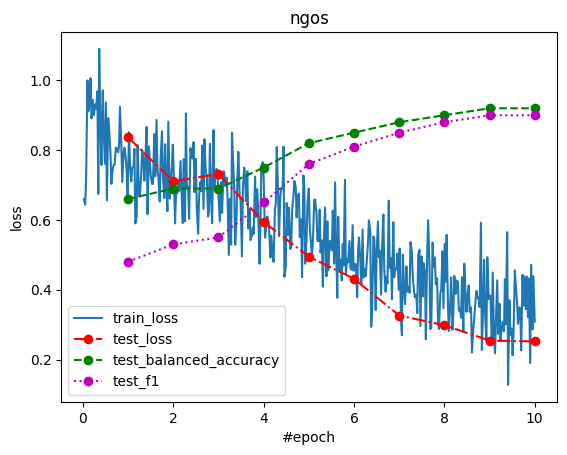

In [102]:
plot_save_results(trainer,name)

Building Twitter Dataset...


Testing: 100%|██████████| 207/207 [00:03<00:00, 53.09it/s]


Evaluation for dataset well_answering
Test model loss=0.034112379051408064
Balanced_accuracy: 0.9195305938345724
Precision: 0.9727891156462585
Recall: 0.8411764705882353
F1: 0.9022082018927444
Roc_auc: 0.9195305938345724
Number of ones in predictions: 147
Number of predictions: 2061

Building Twitter Dataset...


Testing: 100%|██████████| 339/339 [00:06<00:00, 54.65it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.6334961261429947
Balanced_accuracy: 0.76357733175915
Precision: 1.0
Recall: 0.76357733175915
F1: 0.8659414225941422
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 2587
Number of predictions: 3388

Building Twitter Dataset...


Testing: 100%|██████████| 1000/1000 [00:18<00:00, 54.71it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=0.01765322955348529
Balanced_accuracy: 0.9939
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 61
Number of predictions: 10000

Building Twitter Dataset...


Testing: 100%|██████████| 1000/1000 [00:19<00:00, 50.06it/s]


Evaluation for dataset low_answering
Test model loss=1.4938871094934585
Balanced_accuracy: 0.6464552600972633
Precision: 0.03260869565217391
Recall: 0.6464088397790055
F1: 0.0620854338020695
Roc_auc: 0.6464552600972632
Number of ones in predictions: 3588
Number of predictions: 10000

Building Twitter Dataset...


Testing: 100%|██████████| 122/122 [00:02<00:00, 51.26it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=1.1333505284804635
Balanced_accuracy: 0.6368852459016393
Precision: 1.0
Recall: 0.6368852459016393
F1: 0.7781672508763144
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 777
Number of predictions: 1220

Building Twitter Dataset...


Testing: 100%|██████████| 1000/1000 [00:18<00:00, 53.05it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=0.06880675866590172
Balanced_accuracy: 0.9783
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 217
Number of predictions: 10000



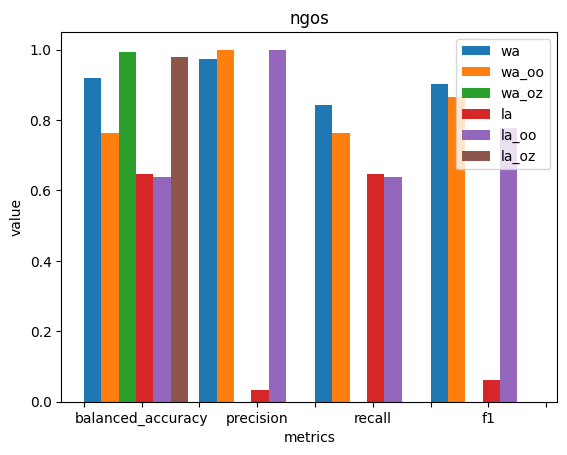

In [159]:
a=evaluate_all_datasets(trainer.model)

### Banks

In [161]:
name="banks"

In [162]:
trainer=training(name,10)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Building Twitter Dataset...
Building Twitter Dataset...


In [163]:
trainer.train()

c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\transformers\optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/11540 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6705, 'learning_rate': 4.956672443674177e-06, 'epoch': 0.09}
{'loss': 0.5518, 'learning_rate': 4.913344887348354e-06, 'epoch': 0.17}
{'loss': 0.5156, 'learning_rate': 4.8700173310225305e-06, 'epoch': 0.26}
{'loss': 0.5011, 'learning_rate': 4.826689774696707e-06, 'epoch': 0.35}
{'loss': 0.4826, 'learning_rate': 4.783362218370884e-06, 'epoch': 0.43}
{'loss': 0.5119, 'learning_rate': 4.740034662045061e-06, 'epoch': 0.52}
{'loss': 0.4956, 'learning_rate': 4.696707105719238e-06, 'epoch': 0.61}
{'loss': 0.4567, 'learning_rate': 4.653379549393415e-06, 'epoch': 0.69}
{'loss': 0.4861, 'learning_rate': 4.6100519930675915e-06, 'epoch': 0.78}
{'loss': 0.455, 'learning_rate': 4.566724436741768e-06, 'epoch': 0.87}
{'loss': 0.4775, 'learning_rate': 4.523396880415945e-06, 'epoch': 0.95}


  0%|          | 0/217 [00:00<?, ?it/s]

{'eval_loss': 0.3926566243171692, 'eval_balanced_accuracy': 0.8, 'eval_precision': 0.7, 'eval_recall': 0.67, 'eval_f1': 0.68, 'eval_runtime': 3.5059, 'eval_samples_per_second': 493.734, 'eval_steps_per_second': 61.895, 'epoch': 1.0}
{'loss': 0.4767, 'learning_rate': 4.4800693240901216e-06, 'epoch': 1.04}
{'loss': 0.447, 'learning_rate': 4.436741767764298e-06, 'epoch': 1.13}
{'loss': 0.4254, 'learning_rate': 4.393414211438475e-06, 'epoch': 1.21}
{'loss': 0.4724, 'learning_rate': 4.350086655112652e-06, 'epoch': 1.3}
{'loss': 0.4396, 'learning_rate': 4.306759098786829e-06, 'epoch': 1.39}
{'loss': 0.4935, 'learning_rate': 4.263431542461005e-06, 'epoch': 1.47}
{'loss': 0.407, 'learning_rate': 4.2201039861351825e-06, 'epoch': 1.56}
{'loss': 0.4728, 'learning_rate': 4.176776429809359e-06, 'epoch': 1.65}
{'loss': 0.4141, 'learning_rate': 4.133448873483536e-06, 'epoch': 1.73}
{'loss': 0.4603, 'learning_rate': 4.090121317157713e-06, 'epoch': 1.82}
{'loss': 0.5181, 'learning_rate': 4.046793760831

  0%|          | 0/217 [00:00<?, ?it/s]

{'eval_loss': 0.5562893152236938, 'eval_balanced_accuracy': 0.78, 'eval_precision': 0.76, 'eval_recall': 0.59, 'eval_f1': 0.67, 'eval_runtime': 3.3873, 'eval_samples_per_second': 511.029, 'eval_steps_per_second': 64.063, 'epoch': 2.0}
{'loss': 0.4318, 'learning_rate': 3.960138648180243e-06, 'epoch': 2.08}
{'loss': 0.4255, 'learning_rate': 3.91681109185442e-06, 'epoch': 2.17}
{'loss': 0.492, 'learning_rate': 3.873483535528596e-06, 'epoch': 2.25}
{'loss': 0.4603, 'learning_rate': 3.830155979202773e-06, 'epoch': 2.34}
{'loss': 0.4441, 'learning_rate': 3.7868284228769504e-06, 'epoch': 2.43}
{'loss': 0.4469, 'learning_rate': 3.743500866551127e-06, 'epoch': 2.51}
{'loss': 0.3728, 'learning_rate': 3.7001733102253033e-06, 'epoch': 2.6}
{'loss': 0.3645, 'learning_rate': 3.6568457538994805e-06, 'epoch': 2.69}
{'loss': 0.5164, 'learning_rate': 3.6135181975736573e-06, 'epoch': 2.77}
{'loss': 0.4764, 'learning_rate': 3.5701906412478338e-06, 'epoch': 2.86}
{'loss': 0.4343, 'learning_rate': 3.5268630

  0%|          | 0/217 [00:00<?, ?it/s]

{'eval_loss': 0.38256996870040894, 'eval_balanced_accuracy': 0.85, 'eval_precision': 0.76, 'eval_recall': 0.75, 'eval_f1': 0.76, 'eval_runtime': 3.3877, 'eval_samples_per_second': 510.971, 'eval_steps_per_second': 64.056, 'epoch': 3.0}
{'loss': 0.4764, 'learning_rate': 3.4835355285961874e-06, 'epoch': 3.03}
{'loss': 0.3732, 'learning_rate': 3.4402079722703643e-06, 'epoch': 3.12}
{'loss': 0.3641, 'learning_rate': 3.396880415944541e-06, 'epoch': 3.21}
{'loss': 0.3468, 'learning_rate': 3.353552859618718e-06, 'epoch': 3.29}
{'loss': 0.4871, 'learning_rate': 3.3102253032928943e-06, 'epoch': 3.38}
{'loss': 0.3753, 'learning_rate': 3.2668977469670716e-06, 'epoch': 3.47}
{'loss': 0.3995, 'learning_rate': 3.223570190641248e-06, 'epoch': 3.55}
{'loss': 0.4107, 'learning_rate': 3.180242634315425e-06, 'epoch': 3.64}
{'loss': 0.38, 'learning_rate': 3.1369150779896017e-06, 'epoch': 3.73}
{'loss': 0.3557, 'learning_rate': 3.0935875216637785e-06, 'epoch': 3.81}
{'loss': 0.4755, 'learning_rate': 3.0502

  0%|          | 0/217 [00:00<?, ?it/s]

{'eval_loss': 0.27875110507011414, 'eval_balanced_accuracy': 0.9, 'eval_precision': 0.78, 'eval_recall': 0.85, 'eval_f1': 0.81, 'eval_runtime': 3.3739, 'eval_samples_per_second': 513.06, 'eval_steps_per_second': 64.318, 'epoch': 4.0}
{'loss': 0.3538, 'learning_rate': 2.9636048526863086e-06, 'epoch': 4.07}
{'loss': 0.3153, 'learning_rate': 2.9202772963604854e-06, 'epoch': 4.16}
{'loss': 0.407, 'learning_rate': 2.8769497400346622e-06, 'epoch': 4.25}
{'loss': 0.3382, 'learning_rate': 2.833622183708839e-06, 'epoch': 4.33}
{'loss': 0.4077, 'learning_rate': 2.7902946273830155e-06, 'epoch': 4.42}
{'loss': 0.458, 'learning_rate': 2.7469670710571927e-06, 'epoch': 4.51}
{'loss': 0.3515, 'learning_rate': 2.703639514731369e-06, 'epoch': 4.59}
{'loss': 0.4501, 'learning_rate': 2.660311958405546e-06, 'epoch': 4.68}
{'loss': 0.331, 'learning_rate': 2.6169844020797232e-06, 'epoch': 4.77}
{'loss': 0.383, 'learning_rate': 2.5736568457538996e-06, 'epoch': 4.85}
{'loss': 0.3404, 'learning_rate': 2.5303292

  0%|          | 0/217 [00:00<?, ?it/s]

{'eval_loss': 0.23944883048534393, 'eval_balanced_accuracy': 0.92, 'eval_precision': 0.77, 'eval_recall': 0.9, 'eval_f1': 0.83, 'eval_runtime': 3.3765, 'eval_samples_per_second': 512.655, 'eval_steps_per_second': 64.267, 'epoch': 5.0}
{'loss': 0.3418, 'learning_rate': 2.4870017331022533e-06, 'epoch': 5.03}
{'loss': 0.3958, 'learning_rate': 2.44367417677643e-06, 'epoch': 5.11}
{'loss': 0.3085, 'learning_rate': 2.400346620450607e-06, 'epoch': 5.2}
{'loss': 0.3144, 'learning_rate': 2.357019064124784e-06, 'epoch': 5.29}
{'loss': 0.3334, 'learning_rate': 2.31369150779896e-06, 'epoch': 5.37}
{'loss': 0.3459, 'learning_rate': 2.270363951473137e-06, 'epoch': 5.46}
{'loss': 0.3648, 'learning_rate': 2.227036395147314e-06, 'epoch': 5.55}
{'loss': 0.3259, 'learning_rate': 2.1837088388214907e-06, 'epoch': 5.63}
{'loss': 0.3378, 'learning_rate': 2.1403812824956675e-06, 'epoch': 5.72}
{'loss': 0.2996, 'learning_rate': 2.0970537261698444e-06, 'epoch': 5.81}
{'loss': 0.3049, 'learning_rate': 2.05372616

  0%|          | 0/217 [00:00<?, ?it/s]

{'eval_loss': 0.24646863341331482, 'eval_balanced_accuracy': 0.93, 'eval_precision': 0.82, 'eval_recall': 0.89, 'eval_f1': 0.85, 'eval_runtime': 3.4037, 'eval_samples_per_second': 508.561, 'eval_steps_per_second': 63.754, 'epoch': 6.0}
{'loss': 0.3288, 'learning_rate': 1.9670710571923744e-06, 'epoch': 6.07}
{'loss': 0.318, 'learning_rate': 1.9237435008665513e-06, 'epoch': 6.15}
{'loss': 0.3027, 'learning_rate': 1.880415944540728e-06, 'epoch': 6.24}
{'loss': 0.2974, 'learning_rate': 1.837088388214905e-06, 'epoch': 6.33}
{'loss': 0.3908, 'learning_rate': 1.7937608318890818e-06, 'epoch': 6.41}
{'loss': 0.2791, 'learning_rate': 1.7504332755632584e-06, 'epoch': 6.5}
{'loss': 0.3154, 'learning_rate': 1.7071057192374352e-06, 'epoch': 6.59}
{'loss': 0.3221, 'learning_rate': 1.663778162911612e-06, 'epoch': 6.67}
{'loss': 0.303, 'learning_rate': 1.6204506065857887e-06, 'epoch': 6.76}
{'loss': 0.3225, 'learning_rate': 1.5771230502599655e-06, 'epoch': 6.85}
{'loss': 0.384, 'learning_rate': 1.53379

  0%|          | 0/217 [00:00<?, ?it/s]

{'eval_loss': 0.2058088779449463, 'eval_balanced_accuracy': 0.94, 'eval_precision': 0.83, 'eval_recall': 0.92, 'eval_f1': 0.87, 'eval_runtime': 3.3937, 'eval_samples_per_second': 510.063, 'eval_steps_per_second': 63.942, 'epoch': 7.0}
{'loss': 0.2881, 'learning_rate': 1.490467937608319e-06, 'epoch': 7.02}
{'loss': 0.3315, 'learning_rate': 1.4471403812824958e-06, 'epoch': 7.11}
{'loss': 0.3075, 'learning_rate': 1.4038128249566726e-06, 'epoch': 7.19}
{'loss': 0.2881, 'learning_rate': 1.3604852686308492e-06, 'epoch': 7.28}
{'loss': 0.2994, 'learning_rate': 1.317157712305026e-06, 'epoch': 7.37}
{'loss': 0.2543, 'learning_rate': 1.273830155979203e-06, 'epoch': 7.45}
{'loss': 0.3233, 'learning_rate': 1.2305025996533797e-06, 'epoch': 7.54}
{'loss': 0.2561, 'learning_rate': 1.1871750433275564e-06, 'epoch': 7.63}
{'loss': 0.3643, 'learning_rate': 1.1438474870017332e-06, 'epoch': 7.71}
{'loss': 0.2946, 'learning_rate': 1.10051993067591e-06, 'epoch': 7.8}
{'loss': 0.3044, 'learning_rate': 1.05719

  0%|          | 0/217 [00:00<?, ?it/s]

{'eval_loss': 0.206107035279274, 'eval_balanced_accuracy': 0.94, 'eval_precision': 0.85, 'eval_recall': 0.91, 'eval_f1': 0.88, 'eval_runtime': 3.3992, 'eval_samples_per_second': 509.243, 'eval_steps_per_second': 63.839, 'epoch': 8.0}
{'loss': 0.25, 'learning_rate': 9.705372616984403e-07, 'epoch': 8.06}
{'loss': 0.246, 'learning_rate': 9.27209705372617e-07, 'epoch': 8.15}
{'loss': 0.3832, 'learning_rate': 8.838821490467939e-07, 'epoch': 8.23}
{'loss': 0.2566, 'learning_rate': 8.405545927209706e-07, 'epoch': 8.32}
{'loss': 0.2373, 'learning_rate': 7.972270363951473e-07, 'epoch': 8.41}
{'loss': 0.2035, 'learning_rate': 7.538994800693242e-07, 'epoch': 8.49}
{'loss': 0.226, 'learning_rate': 7.105719237435009e-07, 'epoch': 8.58}
{'loss': 0.2569, 'learning_rate': 6.672443674176777e-07, 'epoch': 8.67}
{'loss': 0.3085, 'learning_rate': 6.239168110918544e-07, 'epoch': 8.75}
{'loss': 0.2787, 'learning_rate': 5.805892547660313e-07, 'epoch': 8.84}
{'loss': 0.2693, 'learning_rate': 5.37261698440208e

  0%|          | 0/217 [00:00<?, ?it/s]

{'eval_loss': 0.19017842411994934, 'eval_balanced_accuracy': 0.95, 'eval_precision': 0.86, 'eval_recall': 0.92, 'eval_f1': 0.89, 'eval_runtime': 3.3957, 'eval_samples_per_second': 509.766, 'eval_steps_per_second': 63.905, 'epoch': 9.0}
{'loss': 0.2363, 'learning_rate': 4.939341421143848e-07, 'epoch': 9.01}
{'loss': 0.2548, 'learning_rate': 4.5060658578856156e-07, 'epoch': 9.1}
{'loss': 0.2335, 'learning_rate': 4.072790294627384e-07, 'epoch': 9.19}
{'loss': 0.2563, 'learning_rate': 3.6395147313691506e-07, 'epoch': 9.27}
{'loss': 0.3186, 'learning_rate': 3.206239168110919e-07, 'epoch': 9.36}
{'loss': 0.253, 'learning_rate': 2.772963604852686e-07, 'epoch': 9.45}
{'loss': 0.219, 'learning_rate': 2.3396880415944543e-07, 'epoch': 9.53}
{'loss': 0.3037, 'learning_rate': 1.9064124783362218e-07, 'epoch': 9.62}
{'loss': 0.276, 'learning_rate': 1.47313691507799e-07, 'epoch': 9.71}
{'loss': 0.273, 'learning_rate': 1.0398613518197575e-07, 'epoch': 9.79}
{'loss': 0.2516, 'learning_rate': 6.065857885

  0%|          | 0/217 [00:00<?, ?it/s]

{'eval_loss': 0.17837612330913544, 'eval_balanced_accuracy': 0.95, 'eval_precision': 0.86, 'eval_recall': 0.94, 'eval_f1': 0.89, 'eval_runtime': 3.456, 'eval_samples_per_second': 500.868, 'eval_steps_per_second': 62.789, 'epoch': 10.0}
{'train_runtime': 804.6349, 'train_samples_per_second': 114.735, 'train_steps_per_second': 14.342, 'train_loss': 0.36638809878450124, 'epoch': 10.0}


TrainOutput(global_step=11540, training_loss=0.36638809878450124, metrics={'train_runtime': 804.6349, 'train_samples_per_second': 114.735, 'train_steps_per_second': 14.342, 'train_loss': 0.36638809878450124, 'epoch': 10.0})

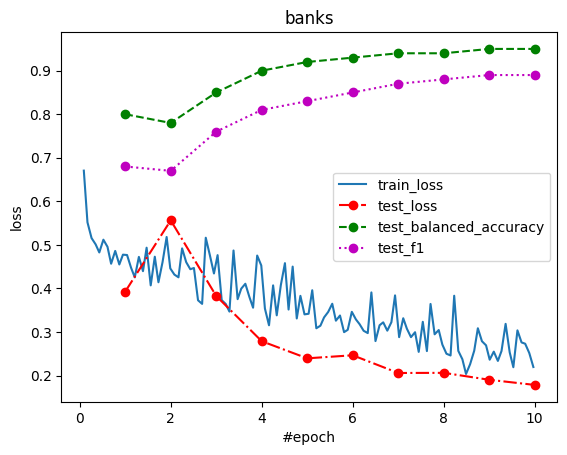

In [164]:
plot_save_results(trainer,name)

Building Twitter Dataset...


Testing: 100%|██████████| 58/58 [00:01<00:00, 47.15it/s]


Evaluation for dataset well_answering
Test model loss=0.06959537407513788
Balanced_accuracy: 0.9474021551896807
Precision: 0.875
Recall: 0.9245283018867925
F1: 0.8990825688073395
Roc_auc: 0.9474021551896807
Number of ones in predictions: 112
Number of predictions: 577

Building Twitter Dataset...


Testing: 100%|██████████| 211/211 [00:03<00:00, 53.10it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.2957417168422774
Balanced_accuracy: 0.8606752258678079
Precision: 1.0
Recall: 0.8606752258678079
F1: 0.9251213902376693
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 1810
Number of predictions: 2103

Building Twitter Dataset...


Testing: 100%|██████████| 944/944 [00:17<00:00, 53.73it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=0.07373737706291002
Balanced_accuracy: 0.9569778531312917
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 406
Number of predictions: 9437

Building Twitter Dataset...


Testing: 100%|██████████| 1000/1000 [00:19<00:00, 50.81it/s]


Evaluation for dataset low_answering
Test model loss=0.3987127682826249
Balanced_accuracy: 0.6281857813547954
Precision: 0.012691466083150985
Recall: 0.48333333333333334
F1: 0.024733475479744138
Roc_auc: 0.6281857813547954
Number of ones in predictions: 2285
Number of predictions: 10000

Building Twitter Dataset...


Testing: 100%|██████████| 7/7 [00:00<00:00, 83.33it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=1.213645100593567
Balanced_accuracy: 0.4918032786885246
Precision: 1.0
Recall: 0.4918032786885246
F1: 0.6593406593406593
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 30
Number of predictions: 61

Building Twitter Dataset...


Testing: 100%|██████████| 1000/1000 [00:18<00:00, 53.14it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=0.39389534514345
Balanced_accuracy: 0.7738
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 2262
Number of predictions: 10000



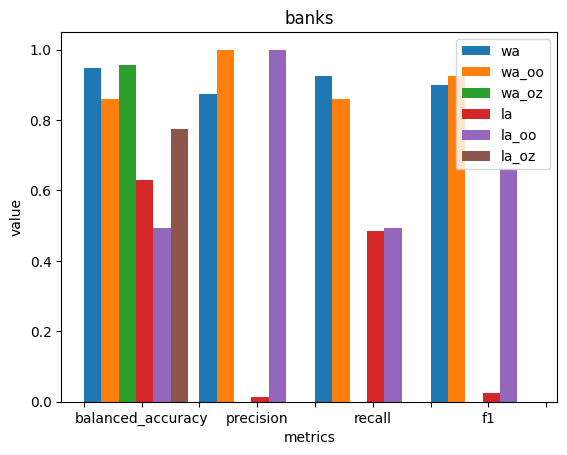

In [165]:
a=evaluate_all_datasets(trainer.model)

### Airlines

In [166]:
name="airlines"

In [167]:
trainer=training(name,10)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Building Twitter Dataset...
Building Twitter Dataset...


In [168]:
trainer.train()

c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\transformers\optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/9180 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6878, 'learning_rate': 4.945533769063181e-06, 'epoch': 0.11}
{'loss': 0.6687, 'learning_rate': 4.891067538126362e-06, 'epoch': 0.22}
{'loss': 0.648, 'learning_rate': 4.836601307189543e-06, 'epoch': 0.33}
{'loss': 0.6305, 'learning_rate': 4.782135076252723e-06, 'epoch': 0.44}
{'loss': 0.6229, 'learning_rate': 4.727668845315904e-06, 'epoch': 0.54}
{'loss': 0.616, 'learning_rate': 4.673202614379085e-06, 'epoch': 0.65}
{'loss': 0.6062, 'learning_rate': 4.618736383442266e-06, 'epoch': 0.76}
{'loss': 0.5986, 'learning_rate': 4.564270152505447e-06, 'epoch': 0.87}
{'loss': 0.5948, 'learning_rate': 4.509803921568628e-06, 'epoch': 0.98}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.5795722007751465, 'eval_balanced_accuracy': 0.7, 'eval_precision': 0.63, 'eval_recall': 0.65, 'eval_f1': 0.64, 'eval_runtime': 2.7541, 'eval_samples_per_second': 499.62, 'eval_steps_per_second': 62.453, 'epoch': 1.0}
{'loss': 0.5808, 'learning_rate': 4.455337690631808e-06, 'epoch': 1.09}
{'loss': 0.5799, 'learning_rate': 4.400871459694989e-06, 'epoch': 1.2}
{'loss': 0.5678, 'learning_rate': 4.34640522875817e-06, 'epoch': 1.31}
{'loss': 0.5705, 'learning_rate': 4.291938997821351e-06, 'epoch': 1.42}
{'loss': 0.5689, 'learning_rate': 4.237472766884531e-06, 'epoch': 1.53}
{'loss': 0.5577, 'learning_rate': 4.183006535947713e-06, 'epoch': 1.63}
{'loss': 0.5701, 'learning_rate': 4.128540305010893e-06, 'epoch': 1.74}
{'loss': 0.5652, 'learning_rate': 4.074074074074074e-06, 'epoch': 1.85}
{'loss': 0.5911, 'learning_rate': 4.019607843137255e-06, 'epoch': 1.96}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.5387794971466064, 'eval_balanced_accuracy': 0.73, 'eval_precision': 0.66, 'eval_recall': 0.71, 'eval_f1': 0.69, 'eval_runtime': 2.8427, 'eval_samples_per_second': 484.046, 'eval_steps_per_second': 60.506, 'epoch': 2.0}
{'loss': 0.528, 'learning_rate': 3.965141612200436e-06, 'epoch': 2.07}
{'loss': 0.5488, 'learning_rate': 3.910675381263617e-06, 'epoch': 2.18}
{'loss': 0.5347, 'learning_rate': 3.856209150326798e-06, 'epoch': 2.29}
{'loss': 0.5526, 'learning_rate': 3.8017429193899785e-06, 'epoch': 2.4}
{'loss': 0.5192, 'learning_rate': 3.747276688453159e-06, 'epoch': 2.51}
{'loss': 0.5315, 'learning_rate': 3.6928104575163404e-06, 'epoch': 2.61}
{'loss': 0.5328, 'learning_rate': 3.638344226579521e-06, 'epoch': 2.72}
{'loss': 0.5432, 'learning_rate': 3.5838779956427015e-06, 'epoch': 2.83}
{'loss': 0.5391, 'learning_rate': 3.529411764705883e-06, 'epoch': 2.94}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.5373644232749939, 'eval_balanced_accuracy': 0.74, 'eval_precision': 0.74, 'eval_recall': 0.63, 'eval_f1': 0.68, 'eval_runtime': 3.0196, 'eval_samples_per_second': 455.685, 'eval_steps_per_second': 56.961, 'epoch': 3.0}
{'loss': 0.5125, 'learning_rate': 3.4749455337690634e-06, 'epoch': 3.05}
{'loss': 0.5029, 'learning_rate': 3.420479302832244e-06, 'epoch': 3.16}
{'loss': 0.5076, 'learning_rate': 3.3660130718954253e-06, 'epoch': 3.27}
{'loss': 0.4953, 'learning_rate': 3.311546840958606e-06, 'epoch': 3.38}
{'loss': 0.4767, 'learning_rate': 3.257080610021787e-06, 'epoch': 3.49}
{'loss': 0.4899, 'learning_rate': 3.2026143790849674e-06, 'epoch': 3.59}
{'loss': 0.5305, 'learning_rate': 3.1481481481481483e-06, 'epoch': 3.7}
{'loss': 0.529, 'learning_rate': 3.0936819172113293e-06, 'epoch': 3.81}
{'loss': 0.5073, 'learning_rate': 3.03921568627451e-06, 'epoch': 3.92}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.46023088693618774, 'eval_balanced_accuracy': 0.8, 'eval_precision': 0.68, 'eval_recall': 0.86, 'eval_f1': 0.76, 'eval_runtime': 2.8497, 'eval_samples_per_second': 482.857, 'eval_steps_per_second': 60.357, 'epoch': 4.0}
{'loss': 0.4887, 'learning_rate': 2.984749455337691e-06, 'epoch': 4.03}
{'loss': 0.4879, 'learning_rate': 2.9302832244008717e-06, 'epoch': 4.14}
{'loss': 0.4496, 'learning_rate': 2.8758169934640523e-06, 'epoch': 4.25}
{'loss': 0.4881, 'learning_rate': 2.8213507625272337e-06, 'epoch': 4.36}
{'loss': 0.4419, 'learning_rate': 2.766884531590414e-06, 'epoch': 4.47}
{'loss': 0.4692, 'learning_rate': 2.7124183006535947e-06, 'epoch': 4.58}
{'loss': 0.4805, 'learning_rate': 2.657952069716776e-06, 'epoch': 4.68}
{'loss': 0.4644, 'learning_rate': 2.6034858387799566e-06, 'epoch': 4.79}
{'loss': 0.4488, 'learning_rate': 2.549019607843137e-06, 'epoch': 4.9}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.4411988854408264, 'eval_balanced_accuracy': 0.81, 'eval_precision': 0.78, 'eval_recall': 0.76, 'eval_f1': 0.77, 'eval_runtime': 2.8106, 'eval_samples_per_second': 489.578, 'eval_steps_per_second': 61.197, 'epoch': 5.0}
{'loss': 0.4676, 'learning_rate': 2.494553376906318e-06, 'epoch': 5.01}
{'loss': 0.4278, 'learning_rate': 2.440087145969499e-06, 'epoch': 5.12}
{'loss': 0.4416, 'learning_rate': 2.38562091503268e-06, 'epoch': 5.23}
{'loss': 0.4459, 'learning_rate': 2.3311546840958606e-06, 'epoch': 5.34}
{'loss': 0.4013, 'learning_rate': 2.2766884531590415e-06, 'epoch': 5.45}
{'loss': 0.402, 'learning_rate': 2.222222222222222e-06, 'epoch': 5.56}
{'loss': 0.4267, 'learning_rate': 2.167755991285403e-06, 'epoch': 5.66}
{'loss': 0.473, 'learning_rate': 2.113289760348584e-06, 'epoch': 5.77}
{'loss': 0.4665, 'learning_rate': 2.058823529411765e-06, 'epoch': 5.88}
{'loss': 0.4472, 'learning_rate': 2.004357298474946e-06, 'epoch': 5.99}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.38192006945610046, 'eval_balanced_accuracy': 0.85, 'eval_precision': 0.79, 'eval_recall': 0.86, 'eval_f1': 0.82, 'eval_runtime': 3.0176, 'eval_samples_per_second': 455.995, 'eval_steps_per_second': 56.999, 'epoch': 6.0}
{'loss': 0.3899, 'learning_rate': 1.9498910675381264e-06, 'epoch': 6.1}
{'loss': 0.3904, 'learning_rate': 1.8954248366013072e-06, 'epoch': 6.21}
{'loss': 0.3837, 'learning_rate': 1.8409586056644881e-06, 'epoch': 6.32}
{'loss': 0.4288, 'learning_rate': 1.786492374727669e-06, 'epoch': 6.43}
{'loss': 0.4381, 'learning_rate': 1.7320261437908499e-06, 'epoch': 6.54}
{'loss': 0.3787, 'learning_rate': 1.6775599128540306e-06, 'epoch': 6.64}
{'loss': 0.3998, 'learning_rate': 1.6230936819172113e-06, 'epoch': 6.75}
{'loss': 0.4015, 'learning_rate': 1.5686274509803923e-06, 'epoch': 6.86}
{'loss': 0.4294, 'learning_rate': 1.5141612200435733e-06, 'epoch': 6.97}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.3589138090610504, 'eval_balanced_accuracy': 0.86, 'eval_precision': 0.83, 'eval_recall': 0.84, 'eval_f1': 0.83, 'eval_runtime': 3.0754, 'eval_samples_per_second': 447.428, 'eval_steps_per_second': 55.929, 'epoch': 7.0}
{'loss': 0.4332, 'learning_rate': 1.4596949891067538e-06, 'epoch': 7.08}
{'loss': 0.4069, 'learning_rate': 1.4052287581699348e-06, 'epoch': 7.19}
{'loss': 0.3548, 'learning_rate': 1.3507625272331157e-06, 'epoch': 7.3}
{'loss': 0.3922, 'learning_rate': 1.2962962962962962e-06, 'epoch': 7.41}
{'loss': 0.3777, 'learning_rate': 1.2418300653594772e-06, 'epoch': 7.52}
{'loss': 0.3625, 'learning_rate': 1.187363834422658e-06, 'epoch': 7.63}
{'loss': 0.3336, 'learning_rate': 1.132897603485839e-06, 'epoch': 7.73}
{'loss': 0.3886, 'learning_rate': 1.0784313725490197e-06, 'epoch': 7.84}
{'loss': 0.3434, 'learning_rate': 1.0239651416122006e-06, 'epoch': 7.95}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.32215961813926697, 'eval_balanced_accuracy': 0.89, 'eval_precision': 0.83, 'eval_recall': 0.9, 'eval_f1': 0.86, 'eval_runtime': 3.2182, 'eval_samples_per_second': 427.569, 'eval_steps_per_second': 53.446, 'epoch': 8.0}
{'loss': 0.3876, 'learning_rate': 9.694989106753814e-07, 'epoch': 8.06}
{'loss': 0.3448, 'learning_rate': 9.150326797385621e-07, 'epoch': 8.17}
{'loss': 0.3874, 'learning_rate': 8.605664488017431e-07, 'epoch': 8.28}
{'loss': 0.3293, 'learning_rate': 8.061002178649238e-07, 'epoch': 8.39}
{'loss': 0.3761, 'learning_rate': 7.516339869281046e-07, 'epoch': 8.5}
{'loss': 0.352, 'learning_rate': 6.971677559912855e-07, 'epoch': 8.61}
{'loss': 0.3622, 'learning_rate': 6.427015250544663e-07, 'epoch': 8.71}
{'loss': 0.3516, 'learning_rate': 5.882352941176471e-07, 'epoch': 8.82}
{'loss': 0.3356, 'learning_rate': 5.33769063180828e-07, 'epoch': 8.93}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.31202808022499084, 'eval_balanced_accuracy': 0.89, 'eval_precision': 0.84, 'eval_recall': 0.9, 'eval_f1': 0.87, 'eval_runtime': 3.212, 'eval_samples_per_second': 428.393, 'eval_steps_per_second': 53.549, 'epoch': 9.0}
{'loss': 0.3403, 'learning_rate': 4.793028322440087e-07, 'epoch': 9.04}
{'loss': 0.3171, 'learning_rate': 4.248366013071896e-07, 'epoch': 9.15}
{'loss': 0.3219, 'learning_rate': 3.7037037037037036e-07, 'epoch': 9.26}
{'loss': 0.3454, 'learning_rate': 3.159041394335512e-07, 'epoch': 9.37}
{'loss': 0.3733, 'learning_rate': 2.6143790849673207e-07, 'epoch': 9.48}
{'loss': 0.359, 'learning_rate': 2.0697167755991287e-07, 'epoch': 9.59}
{'loss': 0.3321, 'learning_rate': 1.525054466230937e-07, 'epoch': 9.69}
{'loss': 0.3525, 'learning_rate': 9.803921568627452e-08, 'epoch': 9.8}
{'loss': 0.3348, 'learning_rate': 4.3572984749455345e-08, 'epoch': 9.91}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.3127799332141876, 'eval_balanced_accuracy': 0.89, 'eval_precision': 0.86, 'eval_recall': 0.89, 'eval_f1': 0.87, 'eval_runtime': 2.7701, 'eval_samples_per_second': 496.725, 'eval_steps_per_second': 62.091, 'epoch': 10.0}
{'train_runtime': 655.365, 'train_samples_per_second': 112.014, 'train_steps_per_second': 14.007, 'train_loss': 0.46245740109279526, 'epoch': 10.0}


TrainOutput(global_step=9180, training_loss=0.46245740109279526, metrics={'train_runtime': 655.365, 'train_samples_per_second': 112.014, 'train_steps_per_second': 14.007, 'train_loss': 0.46245740109279526, 'epoch': 10.0})

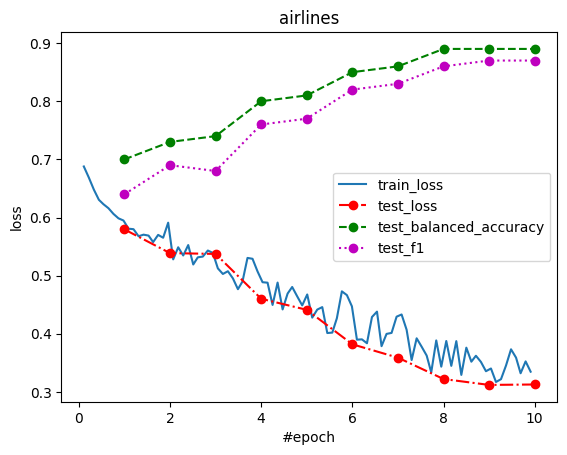

In [169]:
plot_save_results(trainer,name)

Building Twitter Dataset...


Testing: 100%|██████████| 46/46 [00:01<00:00, 43.68it/s]


Evaluation for dataset well_answering
Test model loss=0.13007177430731448
Balanced_accuracy: 0.9156225296442688
Precision: 0.8882978723404256
Recall: 0.907608695652174
F1: 0.8978494623655915
Roc_auc: 0.9156225296442686
Number of ones in predictions: 188
Number of predictions: 459

Building Twitter Dataset...


Testing: 100%|██████████| 357/357 [00:06<00:00, 53.97it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.2463774082383939
Balanced_accuracy: 0.8306700308382394
Precision: 1.0
Recall: 0.8306700308382394
F1: 0.9075038284839203
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 2963
Number of predictions: 3567

Building Twitter Dataset...


Testing: 100%|██████████| 561/561 [00:10<00:00, 51.67it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=0.15664546126948004
Balanced_accuracy: 0.8750222856124086
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 701
Number of predictions: 5609

Building Twitter Dataset...


Testing: 100%|██████████| 948/948 [00:16<00:00, 57.37it/s]


Evaluation for dataset low_answering
Test model loss=0.5123920179903507
Balanced_accuracy: 0.6494590010006533
Precision: 0.3045489591364688
Recall: 0.7829534192269574
F1: 0.43852345267832366
Roc_auc: 0.6494590010006533
Number of ones in predictions: 5188
Number of predictions: 9472

Building Twitter Dataset...


Testing: 100%|██████████| 202/202 [00:03<00:00, 63.17it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=0.2820023210202851
Balanced_accuracy: 0.7829534192269574
Precision: 1.0
Recall: 0.7829534192269574
F1: 0.8782657031684269
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 1580
Number of predictions: 2018

Building Twitter Dataset...


Testing: 100%|██████████| 746/746 [00:12<00:00, 60.48it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=0.5750411134762514
Balanced_accuracy: 0.5159645827743493
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 3608
Number of predictions: 7454



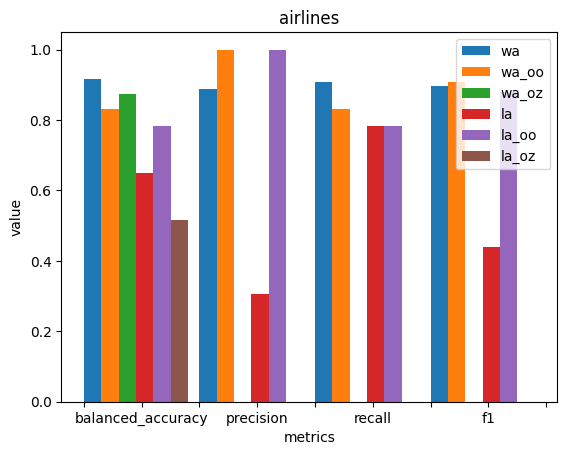

In [170]:
a=evaluate_all_datasets(trainer.model)

### ICRC

In [171]:
name="icrc"

In [172]:
trainer=training(name,10)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Building Twitter Dataset...
Building Twitter Dataset...


In [173]:
trainer.train()

c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\transformers\optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/22110 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6543, 'learning_rate': 4.977385798281321e-06, 'epoch': 0.05}
{'loss': 0.6333, 'learning_rate': 4.954771596562642e-06, 'epoch': 0.09}
{'loss': 0.6337, 'learning_rate': 4.932157394843962e-06, 'epoch': 0.14}
{'loss': 0.9048, 'learning_rate': 4.9095431931252826e-06, 'epoch': 0.18}
{'loss': 0.7416, 'learning_rate': 4.886928991406603e-06, 'epoch': 0.23}
{'loss': 0.8796, 'learning_rate': 4.864314789687924e-06, 'epoch': 0.27}
{'loss': 0.7754, 'learning_rate': 4.841700587969245e-06, 'epoch': 0.32}
{'loss': 0.6972, 'learning_rate': 4.8190863862505664e-06, 'epoch': 0.36}
{'loss': 0.9303, 'learning_rate': 4.796472184531886e-06, 'epoch': 0.41}
{'loss': 0.7787, 'learning_rate': 4.773857982813207e-06, 'epoch': 0.45}
{'loss': 0.7839, 'learning_rate': 4.751243781094528e-06, 'epoch': 0.5}
{'loss': 0.7387, 'learning_rate': 4.728629579375849e-06, 'epoch': 0.54}
{'loss': 0.7694, 'learning_rate': 4.706015377657169e-06, 'epoch': 0.59}
{'loss': 0.8138, 'learning_rate': 4.683401175938489e-06, 'epoch

  0%|          | 0/415 [00:00<?, ?it/s]

{'eval_loss': 0.7573389410972595, 'eval_balanced_accuracy': 0.67, 'eval_precision': 0.91, 'eval_recall': 0.35, 'eval_f1': 0.51, 'eval_runtime': 6.2994, 'eval_samples_per_second': 526.237, 'eval_steps_per_second': 65.879, 'epoch': 1.0}
{'loss': 0.723, 'learning_rate': 4.479873360470376e-06, 'epoch': 1.04}
{'loss': 0.6625, 'learning_rate': 4.457259158751697e-06, 'epoch': 1.09}
{'loss': 0.7646, 'learning_rate': 4.434644957033017e-06, 'epoch': 1.13}
{'loss': 0.7943, 'learning_rate': 4.4120307553143375e-06, 'epoch': 1.18}
{'loss': 0.6819, 'learning_rate': 4.389416553595658e-06, 'epoch': 1.22}
{'loss': 0.9207, 'learning_rate': 4.366802351876979e-06, 'epoch': 1.27}
{'loss': 0.6613, 'learning_rate': 4.3441881501583e-06, 'epoch': 1.31}
{'loss': 0.7089, 'learning_rate': 4.3215739484396205e-06, 'epoch': 1.36}
{'loss': 0.8027, 'learning_rate': 4.298959746720941e-06, 'epoch': 1.4}
{'loss': 0.7314, 'learning_rate': 4.276345545002262e-06, 'epoch': 1.45}
{'loss': 0.7409, 'learning_rate': 4.25373134328

  0%|          | 0/415 [00:00<?, ?it/s]

{'eval_loss': 0.7692996859550476, 'eval_balanced_accuracy': 0.69, 'eval_precision': 0.93, 'eval_recall': 0.39, 'eval_f1': 0.55, 'eval_runtime': 6.3957, 'eval_samples_per_second': 518.314, 'eval_steps_per_second': 64.887, 'epoch': 2.0}
{'loss': 0.6042, 'learning_rate': 3.982360922659431e-06, 'epoch': 2.04}
{'loss': 0.5828, 'learning_rate': 3.959746720940751e-06, 'epoch': 2.08}
{'loss': 0.7981, 'learning_rate': 3.937132519222072e-06, 'epoch': 2.13}
{'loss': 0.6744, 'learning_rate': 3.914518317503392e-06, 'epoch': 2.17}
{'loss': 0.6906, 'learning_rate': 3.891904115784713e-06, 'epoch': 2.22}
{'loss': 0.6793, 'learning_rate': 3.869289914066034e-06, 'epoch': 2.26}
{'loss': 0.6003, 'learning_rate': 3.846675712347355e-06, 'epoch': 2.31}
{'loss': 0.5937, 'learning_rate': 3.8240615106286745e-06, 'epoch': 2.35}
{'loss': 0.7626, 'learning_rate': 3.8014473089099957e-06, 'epoch': 2.4}
{'loss': 0.7177, 'learning_rate': 3.7788331071913164e-06, 'epoch': 2.44}
{'loss': 0.6363, 'learning_rate': 3.7562189

  0%|          | 0/415 [00:00<?, ?it/s]

{'eval_loss': 0.6297149062156677, 'eval_balanced_accuracy': 0.74, 'eval_precision': 0.9, 'eval_recall': 0.49, 'eval_f1': 0.63, 'eval_runtime': 6.6039, 'eval_samples_per_second': 501.974, 'eval_steps_per_second': 62.841, 'epoch': 3.0}
{'loss': 0.6028, 'learning_rate': 3.4848484848484854e-06, 'epoch': 3.03}
{'loss': 0.5449, 'learning_rate': 3.4622342831298057e-06, 'epoch': 3.08}
{'loss': 0.5002, 'learning_rate': 3.4396200814111265e-06, 'epoch': 3.12}
{'loss': 0.5849, 'learning_rate': 3.4170058796924472e-06, 'epoch': 3.17}
{'loss': 0.7171, 'learning_rate': 3.394391677973768e-06, 'epoch': 3.21}
{'loss': 0.7182, 'learning_rate': 3.3717774762550887e-06, 'epoch': 3.26}
{'loss': 0.6588, 'learning_rate': 3.349163274536409e-06, 'epoch': 3.3}
{'loss': 0.6151, 'learning_rate': 3.32654907281773e-06, 'epoch': 3.35}
{'loss': 0.7644, 'learning_rate': 3.3039348710990506e-06, 'epoch': 3.39}
{'loss': 0.5677, 'learning_rate': 3.2813206693803713e-06, 'epoch': 3.44}
{'loss': 0.6117, 'learning_rate': 3.25870

  0%|          | 0/415 [00:00<?, ?it/s]

{'eval_loss': 0.5663646459579468, 'eval_balanced_accuracy': 0.78, 'eval_precision': 0.95, 'eval_recall': 0.56, 'eval_f1': 0.71, 'eval_runtime': 6.1549, 'eval_samples_per_second': 538.596, 'eval_steps_per_second': 67.426, 'epoch': 4.0}
{'loss': 0.5288, 'learning_rate': 2.9873360470375394e-06, 'epoch': 4.03}
{'loss': 0.5692, 'learning_rate': 2.96472184531886e-06, 'epoch': 4.07}
{'loss': 0.5908, 'learning_rate': 2.942107643600181e-06, 'epoch': 4.12}
{'loss': 0.6623, 'learning_rate': 2.9194934418815017e-06, 'epoch': 4.16}
{'loss': 0.53, 'learning_rate': 2.8968792401628224e-06, 'epoch': 4.21}
{'loss': 0.6058, 'learning_rate': 2.8742650384441436e-06, 'epoch': 4.25}
{'loss': 0.4691, 'learning_rate': 2.8516508367254635e-06, 'epoch': 4.3}
{'loss': 0.5684, 'learning_rate': 2.8290366350067843e-06, 'epoch': 4.34}
{'loss': 0.5752, 'learning_rate': 2.806422433288105e-06, 'epoch': 4.39}
{'loss': 0.4771, 'learning_rate': 2.7838082315694258e-06, 'epoch': 4.43}
{'loss': 0.4613, 'learning_rate': 2.761194

  0%|          | 0/415 [00:00<?, ?it/s]

{'eval_loss': 0.43225806951522827, 'eval_balanced_accuracy': 0.84, 'eval_precision': 0.94, 'eval_recall': 0.69, 'eval_f1': 0.79, 'eval_runtime': 6.2016, 'eval_samples_per_second': 534.536, 'eval_steps_per_second': 66.918, 'epoch': 5.0}
{'loss': 0.4901, 'learning_rate': 2.4898236092265947e-06, 'epoch': 5.02}
{'loss': 0.4577, 'learning_rate': 2.467209407507915e-06, 'epoch': 5.07}
{'loss': 0.5328, 'learning_rate': 2.444595205789236e-06, 'epoch': 5.11}
{'loss': 0.577, 'learning_rate': 2.4219810040705565e-06, 'epoch': 5.16}
{'loss': 0.5401, 'learning_rate': 2.399366802351877e-06, 'epoch': 5.2}
{'loss': 0.5744, 'learning_rate': 2.376752600633198e-06, 'epoch': 5.25}
{'loss': 0.4668, 'learning_rate': 2.354138398914519e-06, 'epoch': 5.29}
{'loss': 0.3518, 'learning_rate': 2.331524197195839e-06, 'epoch': 5.34}
{'loss': 0.4216, 'learning_rate': 2.30890999547716e-06, 'epoch': 5.38}
{'loss': 0.446, 'learning_rate': 2.2862957937584802e-06, 'epoch': 5.43}
{'loss': 0.3821, 'learning_rate': 2.263681592

  0%|          | 0/415 [00:00<?, ?it/s]

{'eval_loss': 0.3840974271297455, 'eval_balanced_accuracy': 0.88, 'eval_precision': 0.96, 'eval_recall': 0.76, 'eval_f1': 0.85, 'eval_runtime': 6.3019, 'eval_samples_per_second': 526.03, 'eval_steps_per_second': 65.853, 'epoch': 6.0}
{'loss': 0.3413, 'learning_rate': 1.992311171415649e-06, 'epoch': 6.02}
{'loss': 0.355, 'learning_rate': 1.96969696969697e-06, 'epoch': 6.06}
{'loss': 0.5646, 'learning_rate': 1.9470827679782907e-06, 'epoch': 6.11}
{'loss': 0.3343, 'learning_rate': 1.9244685662596114e-06, 'epoch': 6.15}
{'loss': 0.3751, 'learning_rate': 1.9018543645409318e-06, 'epoch': 6.2}
{'loss': 0.5285, 'learning_rate': 1.8792401628222525e-06, 'epoch': 6.24}
{'loss': 0.4533, 'learning_rate': 1.856625961103573e-06, 'epoch': 6.29}
{'loss': 0.3974, 'learning_rate': 1.8340117593848938e-06, 'epoch': 6.33}
{'loss': 0.3102, 'learning_rate': 1.8113975576662146e-06, 'epoch': 6.38}
{'loss': 0.2295, 'learning_rate': 1.788783355947535e-06, 'epoch': 6.42}
{'loss': 0.309, 'learning_rate': 1.76616915

  0%|          | 0/415 [00:00<?, ?it/s]

{'eval_loss': 0.28946003317832947, 'eval_balanced_accuracy': 0.92, 'eval_precision': 0.96, 'eval_recall': 0.84, 'eval_f1': 0.9, 'eval_runtime': 6.443, 'eval_samples_per_second': 514.512, 'eval_steps_per_second': 64.411, 'epoch': 7.0}
{'loss': 0.3865, 'learning_rate': 1.494798733604704e-06, 'epoch': 7.01}
{'loss': 0.4057, 'learning_rate': 1.4721845318860246e-06, 'epoch': 7.06}
{'loss': 0.3351, 'learning_rate': 1.4495703301673453e-06, 'epoch': 7.1}
{'loss': 0.4854, 'learning_rate': 1.4269561284486657e-06, 'epoch': 7.15}
{'loss': 0.2795, 'learning_rate': 1.4043419267299866e-06, 'epoch': 7.19}
{'loss': 0.2931, 'learning_rate': 1.3817277250113074e-06, 'epoch': 7.24}
{'loss': 0.3347, 'learning_rate': 1.3591135232926277e-06, 'epoch': 7.28}
{'loss': 0.3831, 'learning_rate': 1.3364993215739485e-06, 'epoch': 7.33}
{'loss': 0.2713, 'learning_rate': 1.3138851198552694e-06, 'epoch': 7.37}
{'loss': 0.4507, 'learning_rate': 1.2912709181365898e-06, 'epoch': 7.42}
{'loss': 0.2662, 'learning_rate': 1.26

  0%|          | 0/415 [00:00<?, ?it/s]

{'eval_loss': 0.24256780743598938, 'eval_balanced_accuracy': 0.93, 'eval_precision': 0.96, 'eval_recall': 0.86, 'eval_f1': 0.91, 'eval_runtime': 6.3014, 'eval_samples_per_second': 526.076, 'eval_steps_per_second': 65.859, 'epoch': 8.0}
{'loss': 0.3975, 'learning_rate': 9.972862957937585e-07, 'epoch': 8.01}
{'loss': 0.3674, 'learning_rate': 9.746720940750793e-07, 'epoch': 8.05}
{'loss': 0.3222, 'learning_rate': 9.520578923563999e-07, 'epoch': 8.1}
{'loss': 0.1988, 'learning_rate': 9.294436906377204e-07, 'epoch': 8.14}
{'loss': 0.4473, 'learning_rate': 9.068294889190413e-07, 'epoch': 8.19}
{'loss': 0.2236, 'learning_rate': 8.842152872003618e-07, 'epoch': 8.23}
{'loss': 0.3678, 'learning_rate': 8.616010854816825e-07, 'epoch': 8.28}
{'loss': 0.2601, 'learning_rate': 8.389868837630034e-07, 'epoch': 8.32}
{'loss': 0.3684, 'learning_rate': 8.163726820443239e-07, 'epoch': 8.37}
{'loss': 0.2766, 'learning_rate': 7.937584803256445e-07, 'epoch': 8.41}
{'loss': 0.4395, 'learning_rate': 7.711442786

  0%|          | 0/415 [00:00<?, ?it/s]

{'eval_loss': 0.23415331542491913, 'eval_balanced_accuracy': 0.94, 'eval_precision': 0.97, 'eval_recall': 0.87, 'eval_f1': 0.92, 'eval_runtime': 6.4756, 'eval_samples_per_second': 511.923, 'eval_steps_per_second': 64.087, 'epoch': 9.0}
{'loss': 0.4316, 'learning_rate': 4.997738579828133e-07, 'epoch': 9.0}
{'loss': 0.2051, 'learning_rate': 4.771596562641339e-07, 'epoch': 9.05}
{'loss': 0.3159, 'learning_rate': 4.5454545454545457e-07, 'epoch': 9.09}
{'loss': 0.2169, 'learning_rate': 4.319312528267752e-07, 'epoch': 9.14}
{'loss': 0.3943, 'learning_rate': 4.093170511080959e-07, 'epoch': 9.18}
{'loss': 0.4066, 'learning_rate': 3.8670284938941657e-07, 'epoch': 9.23}
{'loss': 0.3288, 'learning_rate': 3.6408864767073727e-07, 'epoch': 9.27}
{'loss': 0.2731, 'learning_rate': 3.414744459520579e-07, 'epoch': 9.32}
{'loss': 0.1858, 'learning_rate': 3.188602442333786e-07, 'epoch': 9.36}
{'loss': 0.355, 'learning_rate': 2.9624604251469926e-07, 'epoch': 9.41}
{'loss': 0.4216, 'learning_rate': 2.736318

  0%|          | 0/415 [00:00<?, ?it/s]

{'eval_loss': 0.23602992296218872, 'eval_balanced_accuracy': 0.94, 'eval_precision': 0.99, 'eval_recall': 0.87, 'eval_f1': 0.93, 'eval_runtime': 6.3484, 'eval_samples_per_second': 522.183, 'eval_steps_per_second': 65.371, 'epoch': 10.0}
{'train_runtime': 1518.8109, 'train_samples_per_second': 116.42, 'train_steps_per_second': 14.557, 'train_loss': 0.5247791058226766, 'epoch': 10.0}


TrainOutput(global_step=22110, training_loss=0.5247791058226766, metrics={'train_runtime': 1518.8109, 'train_samples_per_second': 116.42, 'train_steps_per_second': 14.557, 'train_loss': 0.5247791058226766, 'epoch': 10.0})

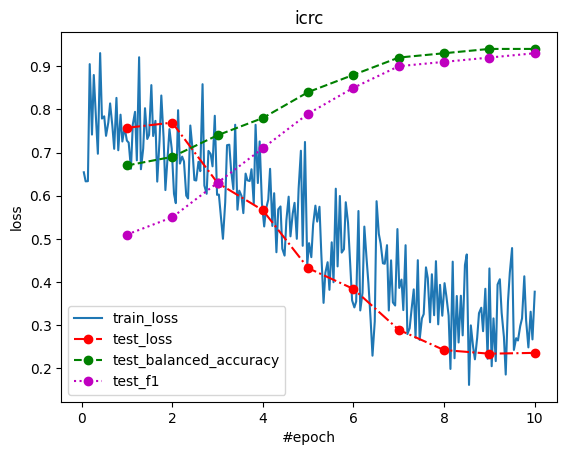

In [174]:
plot_save_results(trainer,name)

Building Twitter Dataset...


Testing: 100%|██████████| 111/111 [00:02<00:00, 49.62it/s]


Evaluation for dataset well_answering
Test model loss=0.02586008222282839
Balanced_accuracy: 0.9480971288371135
Precision: 0.9896907216494846
Recall: 0.897196261682243
F1: 0.9411764705882352
Roc_auc: 0.9480971288371136
Number of ones in predictions: 97
Number of predictions: 1105

Building Twitter Dataset...


Testing: 100%|██████████| 218/218 [00:04<00:00, 51.59it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.5855099893772462
Balanced_accuracy: 0.7793577981651376
Precision: 1.0
Recall: 0.7793577981651376
F1: 0.8759989688063934
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 1699
Number of predictions: 2180

Building Twitter Dataset...


Testing: 100%|██████████| 1000/1000 [00:19<00:00, 51.37it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=0.023661587908456568
Balanced_accuracy: 0.9921
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 79
Number of predictions: 10000

Building Twitter Dataset...


Testing: 100%|██████████| 1000/1000 [00:21<00:00, 47.22it/s]


Evaluation for dataset low_answering
Test model loss=0.4451545643415884
Balanced_accuracy: 0.749032507739938
Precision: 0.13513513513513514
Recall: 0.6066176470588235
F1: 0.22103148024112523
Roc_auc: 0.749032507739938
Number of ones in predictions: 1221
Number of predictions: 10000

Building Twitter Dataset...


Testing: 100%|██████████| 131/131 [00:02<00:00, 51.21it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=1.1722148260488134
Balanced_accuracy: 0.5840978593272171
Precision: 1.0
Recall: 0.5840978593272171
F1: 0.7374517374517374
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 764
Number of predictions: 1308

Building Twitter Dataset...


Testing: 100%|██████████| 1000/1000 [00:19<00:00, 52.56it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=0.08574406095256563
Balanced_accuracy: 0.9703
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 297
Number of predictions: 10000



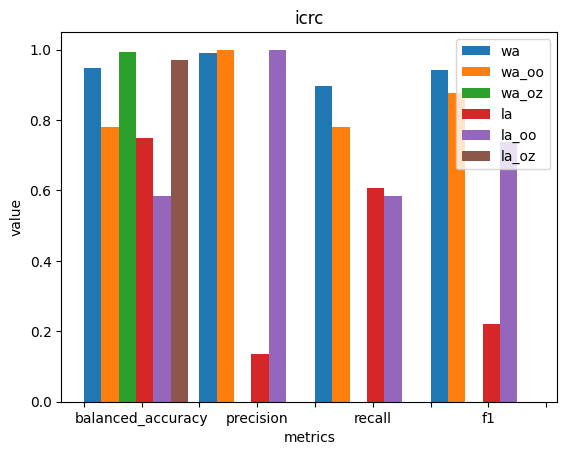

In [175]:
a=evaluate_all_datasets(trainer.model)

### Other NGOs

In [176]:
name="other_ngo"

In [177]:
trainer=training(name,10)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Building Twitter Dataset...
Building Twitter Dataset...


In [178]:
trainer.train()

c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\transformers\optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/13510 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6798, 'learning_rate': 4.96299037749815e-06, 'epoch': 0.07}
{'loss': 0.7092, 'learning_rate': 4.9259807549963e-06, 'epoch': 0.15}
{'loss': 0.9544, 'learning_rate': 4.888971132494449e-06, 'epoch': 0.22}
{'loss': 0.9082, 'learning_rate': 4.8519615099925984e-06, 'epoch': 0.3}
{'loss': 1.0924, 'learning_rate': 4.814951887490748e-06, 'epoch': 0.37}
{'loss': 1.1128, 'learning_rate': 4.777942264988897e-06, 'epoch': 0.44}
{'loss': 0.9767, 'learning_rate': 4.740932642487048e-06, 'epoch': 0.52}
{'loss': 1.1132, 'learning_rate': 4.7039230199851965e-06, 'epoch': 0.59}
{'loss': 1.0381, 'learning_rate': 4.666913397483346e-06, 'epoch': 0.67}
{'loss': 0.8592, 'learning_rate': 4.629903774981496e-06, 'epoch': 0.74}
{'loss': 1.1183, 'learning_rate': 4.592894152479645e-06, 'epoch': 0.81}
{'loss': 0.9107, 'learning_rate': 4.5558845299777945e-06, 'epoch': 0.89}
{'loss': 0.7617, 'learning_rate': 4.518874907475944e-06, 'epoch': 0.96}


  0%|          | 0/254 [00:00<?, ?it/s]

c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.852306604385376, 'eval_balanced_accuracy': 0.5, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.9387, 'eval_samples_per_second': 514.378, 'eval_steps_per_second': 64.488, 'epoch': 1.0}
{'loss': 0.9561, 'learning_rate': 4.481865284974093e-06, 'epoch': 1.04}
{'loss': 0.8053, 'learning_rate': 4.444855662472244e-06, 'epoch': 1.11}
{'loss': 0.9173, 'learning_rate': 4.4078460399703925e-06, 'epoch': 1.18}
{'loss': 0.7421, 'learning_rate': 4.370836417468542e-06, 'epoch': 1.26}
{'loss': 0.8253, 'learning_rate': 4.333826794966692e-06, 'epoch': 1.33}
{'loss': 0.8167, 'learning_rate': 4.296817172464841e-06, 'epoch': 1.41}
{'loss': 0.6286, 'learning_rate': 4.259807549962991e-06, 'epoch': 1.48}
{'loss': 0.6859, 'learning_rate': 4.22279792746114e-06, 'epoch': 1.55}
{'loss': 0.7233, 'learning_rate': 4.18578830495929e-06, 'epoch': 1.63}
{'loss': 0.8096, 'learning_rate': 4.14877868245744e-06, 'epoch': 1.7}
{'loss': 0.7795, 'learning_rate': 4.1117690599555885e

  0%|          | 0/254 [00:00<?, ?it/s]

{'eval_loss': 0.7655171155929565, 'eval_balanced_accuracy': 0.67, 'eval_precision': 0.86, 'eval_recall': 0.35, 'eval_f1': 0.5, 'eval_runtime': 4.2025, 'eval_samples_per_second': 482.091, 'eval_steps_per_second': 60.44, 'epoch': 2.0}
{'loss': 0.5815, 'learning_rate': 3.963730569948187e-06, 'epoch': 2.07}
{'loss': 0.7179, 'learning_rate': 3.926720947446336e-06, 'epoch': 2.15}
{'loss': 0.5475, 'learning_rate': 3.889711324944486e-06, 'epoch': 2.22}
{'loss': 0.6998, 'learning_rate': 3.852701702442636e-06, 'epoch': 2.29}
{'loss': 0.7998, 'learning_rate': 3.815692079940785e-06, 'epoch': 2.37}
{'loss': 0.8005, 'learning_rate': 3.7786824574389347e-06, 'epoch': 2.44}
{'loss': 0.5716, 'learning_rate': 3.741672834937084e-06, 'epoch': 2.52}
{'loss': 0.691, 'learning_rate': 3.7046632124352333e-06, 'epoch': 2.59}
{'loss': 0.7595, 'learning_rate': 3.667653589933383e-06, 'epoch': 2.66}
{'loss': 0.7825, 'learning_rate': 3.6306439674315323e-06, 'epoch': 2.74}
{'loss': 0.6574, 'learning_rate': 3.593634344

  0%|          | 0/254 [00:00<?, ?it/s]

{'eval_loss': 0.7749547362327576, 'eval_balanced_accuracy': 0.69, 'eval_precision': 0.93, 'eval_recall': 0.38, 'eval_f1': 0.54, 'eval_runtime': 4.0825, 'eval_samples_per_second': 496.262, 'eval_steps_per_second': 62.216, 'epoch': 3.0}
{'loss': 0.6062, 'learning_rate': 3.4826054774241308e-06, 'epoch': 3.03}
{'loss': 0.7833, 'learning_rate': 3.44559585492228e-06, 'epoch': 3.11}
{'loss': 0.4773, 'learning_rate': 3.4085862324204294e-06, 'epoch': 3.18}
{'loss': 0.6105, 'learning_rate': 3.371576609918579e-06, 'epoch': 3.26}
{'loss': 0.6349, 'learning_rate': 3.3345669874167288e-06, 'epoch': 3.33}
{'loss': 0.6236, 'learning_rate': 3.297557364914878e-06, 'epoch': 3.4}
{'loss': 0.6724, 'learning_rate': 3.260547742413028e-06, 'epoch': 3.48}
{'loss': 0.6817, 'learning_rate': 3.223538119911177e-06, 'epoch': 3.55}
{'loss': 0.6974, 'learning_rate': 3.186528497409327e-06, 'epoch': 3.63}
{'loss': 0.6022, 'learning_rate': 3.149518874907476e-06, 'epoch': 3.7}
{'loss': 0.8298, 'learning_rate': 3.112509252

  0%|          | 0/254 [00:00<?, ?it/s]

{'eval_loss': 0.6743004322052002, 'eval_balanced_accuracy': 0.71, 'eval_precision': 0.9, 'eval_recall': 0.43, 'eval_f1': 0.58, 'eval_runtime': 3.9214, 'eval_samples_per_second': 516.656, 'eval_steps_per_second': 64.773, 'epoch': 4.0}
{'loss': 0.4996, 'learning_rate': 2.964470762398224e-06, 'epoch': 4.07}
{'loss': 0.5922, 'learning_rate': 2.927461139896373e-06, 'epoch': 4.15}
{'loss': 0.5412, 'learning_rate': 2.890451517394523e-06, 'epoch': 4.22}
{'loss': 0.7325, 'learning_rate': 2.853441894892672e-06, 'epoch': 4.29}
{'loss': 0.5806, 'learning_rate': 2.8164322723908214e-06, 'epoch': 4.37}
{'loss': 0.6577, 'learning_rate': 2.7794226498889716e-06, 'epoch': 4.44}
{'loss': 0.5633, 'learning_rate': 2.742413027387121e-06, 'epoch': 4.52}
{'loss': 0.3657, 'learning_rate': 2.7054034048852706e-06, 'epoch': 4.59}
{'loss': 0.807, 'learning_rate': 2.66839378238342e-06, 'epoch': 4.66}
{'loss': 0.711, 'learning_rate': 2.631384159881569e-06, 'epoch': 4.74}
{'loss': 0.6001, 'learning_rate': 2.5943745373

  0%|          | 0/254 [00:00<?, ?it/s]

{'eval_loss': 0.5266098976135254, 'eval_balanced_accuracy': 0.76, 'eval_precision': 0.9, 'eval_recall': 0.53, 'eval_f1': 0.67, 'eval_runtime': 4.058, 'eval_samples_per_second': 499.261, 'eval_steps_per_second': 62.592, 'epoch': 5.0}
{'loss': 0.5309, 'learning_rate': 2.4833456698741676e-06, 'epoch': 5.03}
{'loss': 0.4779, 'learning_rate': 2.446336047372317e-06, 'epoch': 5.11}
{'loss': 0.6031, 'learning_rate': 2.4093264248704666e-06, 'epoch': 5.18}
{'loss': 0.6255, 'learning_rate': 2.372316802368616e-06, 'epoch': 5.26}
{'loss': 0.6172, 'learning_rate': 2.3353071798667656e-06, 'epoch': 5.33}
{'loss': 0.6096, 'learning_rate': 2.298297557364915e-06, 'epoch': 5.4}
{'loss': 0.4745, 'learning_rate': 2.2612879348630647e-06, 'epoch': 5.48}
{'loss': 0.6812, 'learning_rate': 2.224278312361214e-06, 'epoch': 5.55}
{'loss': 0.6469, 'learning_rate': 2.1872686898593637e-06, 'epoch': 5.63}
{'loss': 0.6881, 'learning_rate': 2.150259067357513e-06, 'epoch': 5.7}
{'loss': 0.5345, 'learning_rate': 2.11324944

  0%|          | 0/254 [00:00<?, ?it/s]

{'eval_loss': 0.5103117227554321, 'eval_balanced_accuracy': 0.81, 'eval_precision': 0.96, 'eval_recall': 0.61, 'eval_f1': 0.75, 'eval_runtime': 3.9481, 'eval_samples_per_second': 513.153, 'eval_steps_per_second': 64.334, 'epoch': 6.0}
{'loss': 0.5156, 'learning_rate': 1.9652109548482607e-06, 'epoch': 6.07}
{'loss': 0.5142, 'learning_rate': 1.9282013323464104e-06, 'epoch': 6.14}
{'loss': 0.5013, 'learning_rate': 1.8911917098445597e-06, 'epoch': 6.22}
{'loss': 0.4312, 'learning_rate': 1.8541820873427094e-06, 'epoch': 6.29}
{'loss': 0.6098, 'learning_rate': 1.8171724648408587e-06, 'epoch': 6.37}
{'loss': 0.4069, 'learning_rate': 1.7801628423390082e-06, 'epoch': 6.44}
{'loss': 0.6791, 'learning_rate': 1.743153219837158e-06, 'epoch': 6.51}
{'loss': 0.519, 'learning_rate': 1.7061435973353074e-06, 'epoch': 6.59}
{'loss': 0.5981, 'learning_rate': 1.6691339748334567e-06, 'epoch': 6.66}
{'loss': 0.5877, 'learning_rate': 1.6321243523316062e-06, 'epoch': 6.74}
{'loss': 0.526, 'learning_rate': 1.59

  0%|          | 0/254 [00:00<?, ?it/s]

{'eval_loss': 0.423846036195755, 'eval_balanced_accuracy': 0.85, 'eval_precision': 0.96, 'eval_recall': 0.71, 'eval_f1': 0.82, 'eval_runtime': 3.9522, 'eval_samples_per_second': 512.623, 'eval_steps_per_second': 64.268, 'epoch': 7.0}
{'loss': 0.4387, 'learning_rate': 1.4840858623242045e-06, 'epoch': 7.03}
{'loss': 0.5962, 'learning_rate': 1.447076239822354e-06, 'epoch': 7.11}
{'loss': 0.436, 'learning_rate': 1.4100666173205035e-06, 'epoch': 7.18}
{'loss': 0.4693, 'learning_rate': 1.3730569948186528e-06, 'epoch': 7.25}
{'loss': 0.4958, 'learning_rate': 1.3360473723168025e-06, 'epoch': 7.33}
{'loss': 0.3613, 'learning_rate': 1.299037749814952e-06, 'epoch': 7.4}
{'loss': 0.5562, 'learning_rate': 1.2620281273131015e-06, 'epoch': 7.48}
{'loss': 0.5361, 'learning_rate': 1.225018504811251e-06, 'epoch': 7.55}
{'loss': 0.6443, 'learning_rate': 1.1880088823094005e-06, 'epoch': 7.62}
{'loss': 0.3759, 'learning_rate': 1.15099925980755e-06, 'epoch': 7.7}
{'loss': 0.3671, 'learning_rate': 1.11398963

  0%|          | 0/254 [00:00<?, ?it/s]

{'eval_loss': 0.38883310556411743, 'eval_balanced_accuracy': 0.86, 'eval_precision': 0.96, 'eval_recall': 0.72, 'eval_f1': 0.82, 'eval_runtime': 4.0115, 'eval_samples_per_second': 505.043, 'eval_steps_per_second': 63.317, 'epoch': 8.0}
{'loss': 0.5824, 'learning_rate': 9.659511472982978e-07, 'epoch': 8.07}
{'loss': 0.2492, 'learning_rate': 9.289415247964472e-07, 'epoch': 8.14}
{'loss': 0.4829, 'learning_rate': 8.919319022945968e-07, 'epoch': 8.22}
{'loss': 0.2818, 'learning_rate': 8.549222797927462e-07, 'epoch': 8.29}
{'loss': 0.5188, 'learning_rate': 8.179126572908958e-07, 'epoch': 8.36}
{'loss': 0.3792, 'learning_rate': 7.809030347890452e-07, 'epoch': 8.44}
{'loss': 0.418, 'learning_rate': 7.438934122871948e-07, 'epoch': 8.51}
{'loss': 0.5681, 'learning_rate': 7.068837897853442e-07, 'epoch': 8.59}
{'loss': 0.5112, 'learning_rate': 6.698741672834938e-07, 'epoch': 8.66}
{'loss': 0.3748, 'learning_rate': 6.328645447816432e-07, 'epoch': 8.73}
{'loss': 0.3906, 'learning_rate': 5.958549222

  0%|          | 0/254 [00:00<?, ?it/s]

{'eval_loss': 0.43894049525260925, 'eval_balanced_accuracy': 0.85, 'eval_precision': 0.98, 'eval_recall': 0.7, 'eval_f1': 0.82, 'eval_runtime': 3.9097, 'eval_samples_per_second': 518.204, 'eval_steps_per_second': 64.967, 'epoch': 9.0}
{'loss': 0.4824, 'learning_rate': 4.848260547742413e-07, 'epoch': 9.03}
{'loss': 0.3244, 'learning_rate': 4.478164322723909e-07, 'epoch': 9.1}
{'loss': 0.5549, 'learning_rate': 4.108068097705404e-07, 'epoch': 9.18}
{'loss': 0.4289, 'learning_rate': 3.737971872686899e-07, 'epoch': 9.25}
{'loss': 0.4624, 'learning_rate': 3.367875647668394e-07, 'epoch': 9.33}
{'loss': 0.2904, 'learning_rate': 2.997779422649889e-07, 'epoch': 9.4}
{'loss': 0.441, 'learning_rate': 2.6276831976313847e-07, 'epoch': 9.47}
{'loss': 0.4217, 'learning_rate': 2.2575869726128798e-07, 'epoch': 9.55}
{'loss': 0.4612, 'learning_rate': 1.8874907475943748e-07, 'epoch': 9.62}
{'loss': 0.5155, 'learning_rate': 1.5173945225758699e-07, 'epoch': 9.7}
{'loss': 0.3151, 'learning_rate': 1.147298297

  0%|          | 0/254 [00:00<?, ?it/s]

{'eval_loss': 0.4271170198917389, 'eval_balanced_accuracy': 0.86, 'eval_precision': 0.98, 'eval_recall': 0.72, 'eval_f1': 0.83, 'eval_runtime': 4.073, 'eval_samples_per_second': 497.422, 'eval_steps_per_second': 62.362, 'epoch': 10.0}
{'train_runtime': 918.7429, 'train_samples_per_second': 117.606, 'train_steps_per_second': 14.705, 'train_loss': 0.6167643979070453, 'epoch': 10.0}


TrainOutput(global_step=13510, training_loss=0.6167643979070453, metrics={'train_runtime': 918.7429, 'train_samples_per_second': 117.606, 'train_steps_per_second': 14.705, 'train_loss': 0.6167643979070453, 'epoch': 10.0})

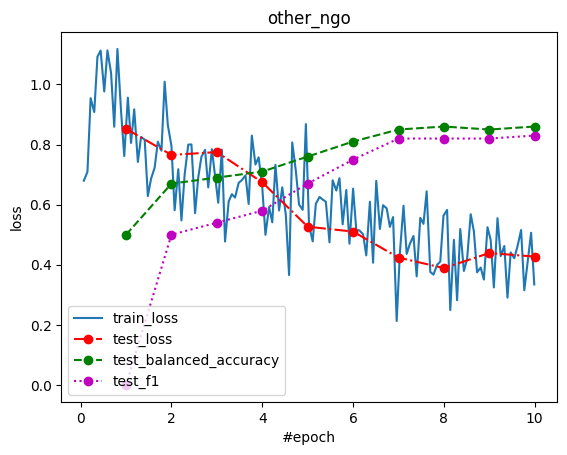

In [179]:
plot_save_results(trainer,name)

Building Twitter Dataset...


Testing: 100%|██████████| 68/68 [00:01<00:00, 49.15it/s]


Evaluation for dataset well_answering
Test model loss=0.06128070251083152
Balanced_accuracy: 0.8470311743969032
Precision: 0.9696969696969697
Recall: 0.6956521739130435
F1: 0.810126582278481
Roc_auc: 0.8470311743969032
Number of ones in predictions: 33
Number of predictions: 675

Building Twitter Dataset...


Testing: 100%|██████████| 92/92 [00:01<00:00, 51.83it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.8536335927403896
Balanced_accuracy: 0.6608505997818975
Precision: 1.0
Recall: 0.6608505997818975
F1: 0.7957977675640184
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 606
Number of predictions: 917

Building Twitter Dataset...


Testing: 100%|██████████| 1000/1000 [00:17<00:00, 56.45it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=0.011411050008580788
Balanced_accuracy: 0.996
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 40
Number of predictions: 10000

Building Twitter Dataset...


Testing: 100%|██████████| 1000/1000 [00:18<00:00, 53.14it/s]


Evaluation for dataset low_answering
Test model loss=3.132541338920593
Balanced_accuracy: 0.6099193128237009
Precision: 0.008940666486047142
Recall: 0.9565217391304348
F1: 0.01771574285330828
Roc_auc: 0.6099193128237009
Number of ones in predictions: 7382
Number of predictions: 10000

Building Twitter Dataset...


Testing: 100%|██████████| 21/21 [00:00<00:00, 57.38it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=0.11521104452168358
Balanced_accuracy: 0.9264705882352942
Precision: 1.0
Recall: 0.9264705882352942
F1: 0.9618320610687023
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 189
Number of predictions: 204

Building Twitter Dataset...


Testing: 100%|██████████| 1000/1000 [00:16<00:00, 62.45it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=1.8480098823740554
Balanced_accuracy: 0.575
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 4250
Number of predictions: 10000



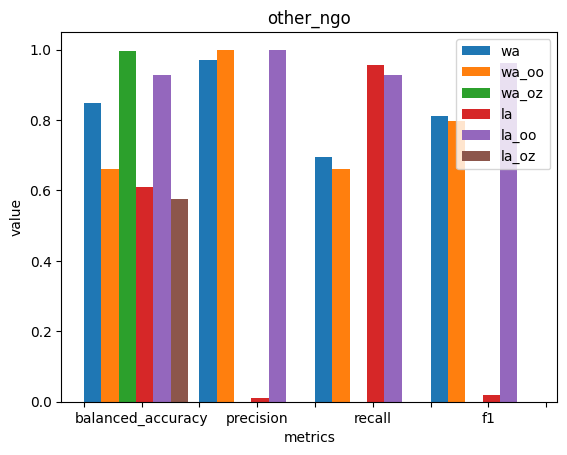

In [180]:
a=evaluate_all_datasets(trainer.model)